# Trends with quasar properties $(M_{i}, M_{BH}, z)$

* [MagnesiumII trends](#mgiiTrends)
  * [MgII : Fig.26](#Fig26) 

* [Quasar properties: Fig.12 ](#qsoProperties)

* [Quasar trends: Fig.13 ](#qsoTrends)


In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import os
import pandas as pd
#import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from scipy.stats import binned_statistic as bs 
from scipy.stats import binned_statistic_2d
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Make Fig. 12, but only plot the distribution of Shen2011, since that's the one I end up using ... '

In [6]:
# Read the Celerite results joined on dbID  to DBQSO  - thus it has DR7 data 
#celerite  = Table.read("190409_Celerite_real_Jeff1_radec.txt", format='ascii')
celerite  = Table.read("../code2/190807_Celerite_real_Jeff1_radec.txt", format='ascii')

# Add Shen2011
cat = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGLBOL_ERR','LOGL_MGII','LOGL_MGII_ERR','FWHM_MGII',
        'FWHM_MGII_ERR','EW_MGII', 'EW_MGII_ERR',    
        'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]

# crossmatch 
cat1 = SkyCoord(ra=celerite['ra']*u.degree, 
                dec=celerite['dec']*u.degree)
cat2 = SkyCoord(ra=shen2011['RA']*u.degree,
                dec=shen2011['DEC']*u.degree, frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
qso = hstack([celerite, shen2011[idx]])

## MgII Trends <a id='mgiiTrends'></a>

First, find the boundaries on  MgII params... 

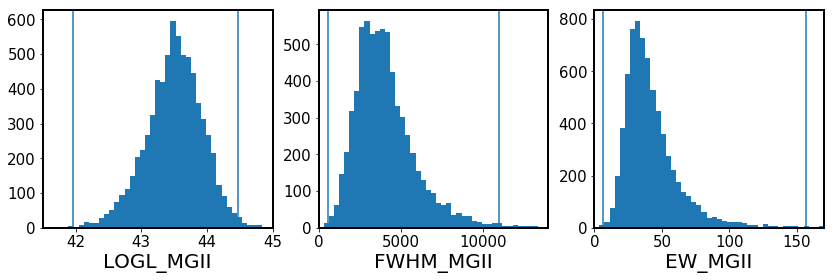

In [55]:
# find boundaries from percentiles of the data 
# illustrate :
fig,ax = plt.subplots(1,3, figsize=(14,4))
i = 0 
xlims = [
         [41.5,45], 
         [0,14000],
         [0,170]
        ]
for col in ['LOGL_MGII', 'FWHM_MGII', 'EW_MGII']:
    m = qso[col] > 0 
    x = qso[col][m]
    
    ax[i].hist(x, bins=45, range = (xlims[i][0],xlims[i][1]))
    ax[i].axvline(np.percentile(x,0.1))
    ax[i].axvline(np.percentile(x,99))
    ax[i].set_xlabel(col)
    ax[i].set_xlim(xlims[i][0],xlims[i][1] )
    i += 1 

In [ ]:
# Well,  the EW gets extremely wide - better to just set it manually then ... 


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


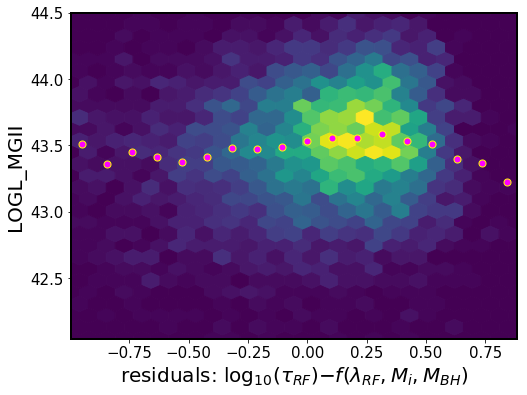

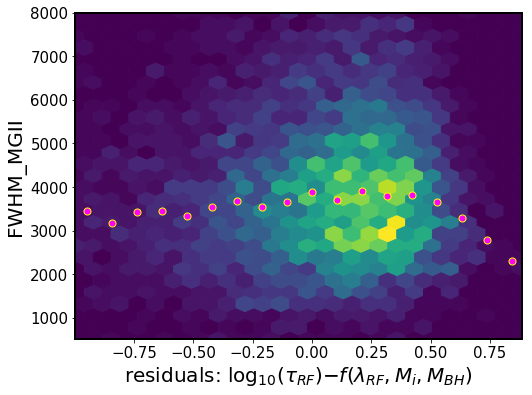

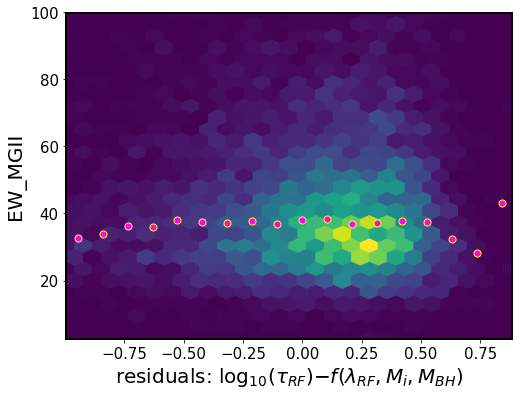

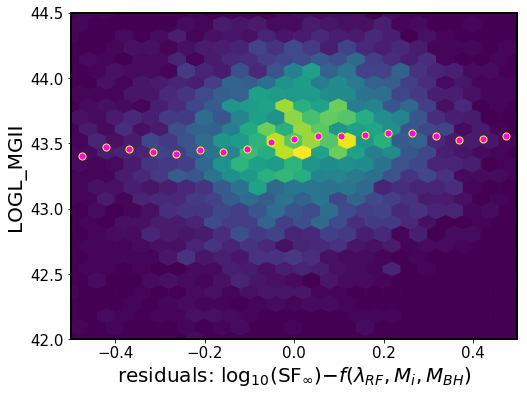

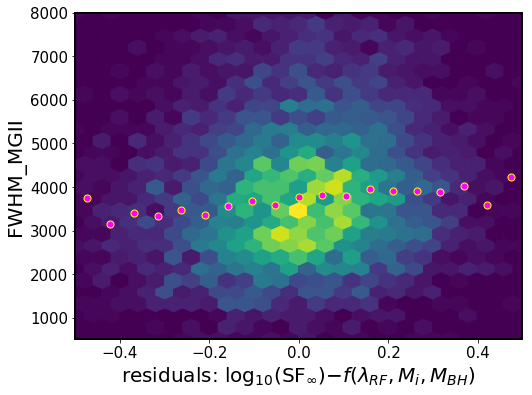

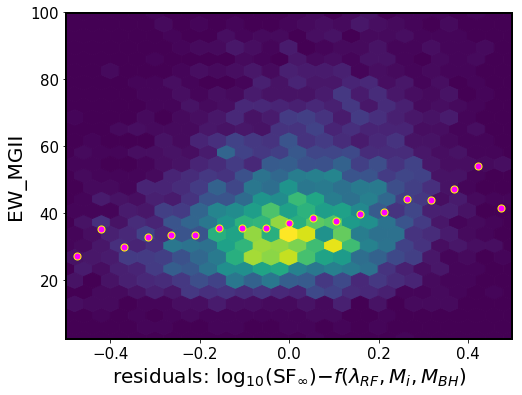

In [67]:
from scipy.stats import binned_statistic as bs 
# plot against anything MGII - related.... any trends ?  
# LOGL_MGII	 LOGL_MGII_ERR	FWHM_MGII	FWHM_MGII_ERR	EW_MGII	EW_MGII_ERR

xlims = [
         [42,44.5], 
         [0,8000],
         [0,100]
        ]


# add column with lambdaRF 
lambdaobs = 6250 
qso['lambdaRF'] = lambdaobs /  (1.+qso['REDSHIFT'])
x = np.log10(qso['lambdaRF']/4000)
y = qso['MI_Z2']+23
z = qso['LOGBH'] - 9 


logtauRF = np.log10(qso['tauEXP_sdss-ps1']) - np.log10(1.0+qso['REDSHIFT'])
logSF = np.log10(np.sqrt(2) *qso['sigmaEXP_sdss-ps1'] )   # SFinf = sqrt(2) * sigma  

f_dic  = {'tau' : logtauRF , 'SF' : logSF}
for par in f_dic.keys():
    f = f_dic[par]
    if par is 'tau':
        A = 2.673 ; B = 0.17 ; C = 0.034 ; D  = 0.181
        pre = r'$\log_{10}(\tau_{RF})$'
        xlim = [-1,1]
    if par is 'SF':
        A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297
        pre = r'$\log_{10}(\mathrm{SF}_{\infty})$'
        xlim = [-.5,.5]
        
    # remove the trends to get resisuals 
    f1 = f -A-  B*x - C*y - D*z 

    i = 0 
    for col in ['LOGL_MGII', 'FWHM_MGII', 'EW_MGII']:
        m1 = qso[col] > 0
        
        ylim = xlims[i]

        m2 = (xlim[0]<f1)&(f1<xlim[1])&(ylim[0]<qso[col]) & (qso[col]<ylim[1])
        m = m1 & m2 

        fig, ax=  plt.subplots(1,1,figsize=(8,6))
        ax.hexbin(f1[m],qso[col][m], gridsize=25)

        # calculate medians 
        bin_edges = np.linspace(xlim[0],xlim[1],20)
        stat_med, bin_edges1,  binnumber = bs(f1[m],qso[col][m],statistic='median', 
                                              bins=bin_edges)
        bin_centers = (bin_edges1[1:] + bin_edges1[:-1] ) /2.
        ax.scatter(bin_centers , stat_med, c = 'magenta', edgecolor='yellow',
                  s=50)
           
        ax.set_xlabel('residuals: '+ pre +r'$-f(\lambda_{RF}, M_{i}, M_{BH})$')
        ax.set_ylabel(col)
        plt.savefig('190807_SDSS-PS1_residuals_'+par+'_vs_'+col+'.png',
                   bbox_inches='tight', dpi=100)
        i += 1 

Flip the axes for that : 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


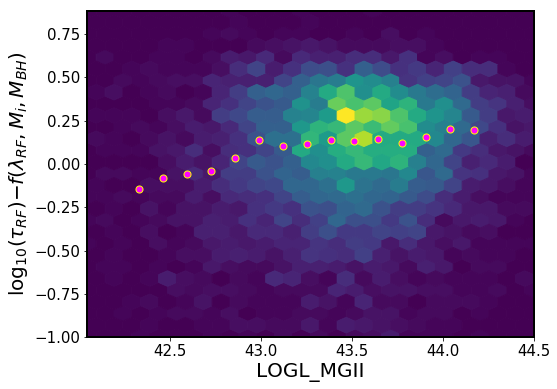

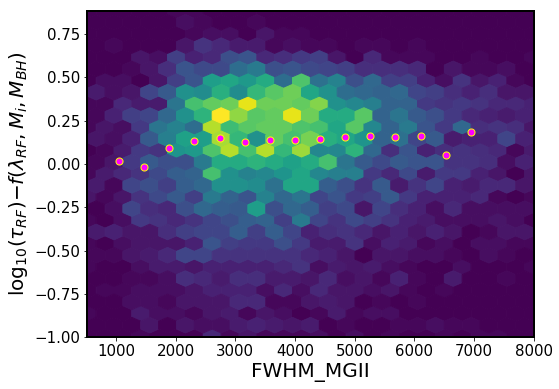

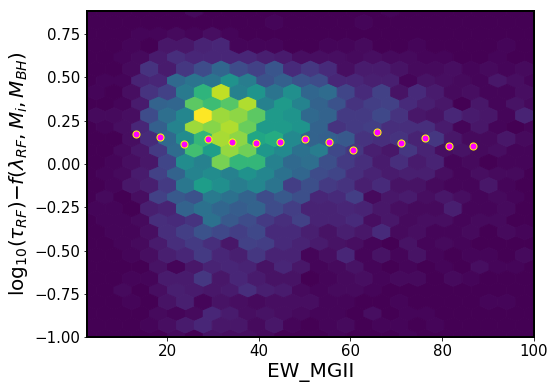

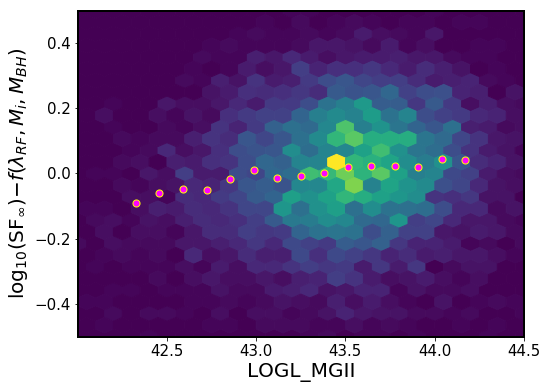

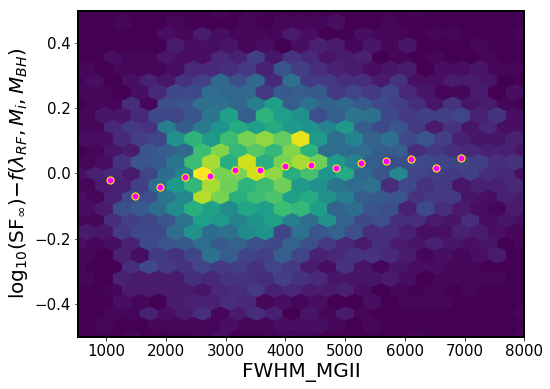

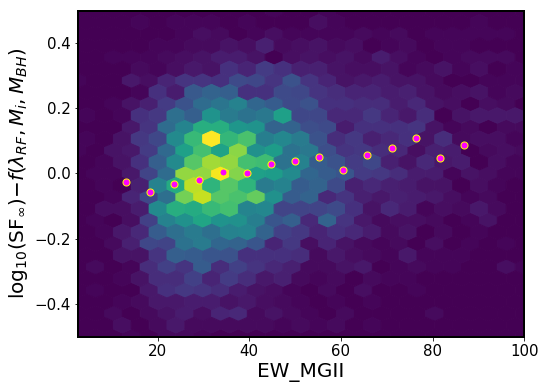

In [137]:
from scipy.stats import binned_statistic as bs 
# plot against anything MGII - related.... any trends ?  
# LOGL_MGII	 LOGL_MGII_ERR	FWHM_MGII	FWHM_MGII_ERR	EW_MGII	EW_MGII_ERR

xlims = [[42,44.5], [0,8000],[0,100]]

# add column with lambdaRF 
lambdaobs = 6250 
qso['lambdaRF'] = lambdaobs /  (1.+qso['REDSHIFT'])

# give names that simplify the model:
# log(f) = A + Bx + Cy + Dz 
x = np.log10(qso['lambdaRF']/4000)
y = qso['MI_Z2']+23
z = qso['LOGBH'] - 9 


logtauRF = np.log10(qso['tauEXP_sdss-ps1']) - np.log10(1.0+qso['REDSHIFT'])
logSF = np.log10(np.sqrt(2) *qso['sigmaEXP_sdss-ps1'] )   # SFinf = sqrt(2) * sigma  
f_dic  = {'tau' : logtauRF , 'SF' : logSF}

for par in f_dic.keys():
    f = f_dic[par]
    if par is 'tau':
        A = 2.673 ; B = 0.17 ; C = 0.034 ; D  = 0.181
        pre = r'$\log_{10}(\tau_{RF})$'
        ylim = [-1,1]
    if par is 'SF':
        A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297
        pre = r'$\log_{10}(\mathrm{SF}_{\infty})$'
        ylim = [-.5,.5]
        
    # remove the trends to get resisuals 
    f1 = f -A-  B*x - C*y - D*z 

    i = 0 
    for col in ['LOGL_MGII', 'FWHM_MGII', 'EW_MGII']:
        m1 = qso[col] > 0
        X = qso[col]
        Y = f1
        
        xlim = xlims[i]

        m2 = (ylim[0]<Y)&(Y<ylim[1])&(xlim[0]<X) & (X<xlim[1])
        m = m1 & m2 

        fig, ax=  plt.subplots(1,1,figsize=(8,6))
        ax.hexbin(X[m], Y[m], gridsize=25)

        # calculate medians 
        bins = np.linspace(xlim[0],xlim[1],20)
        bin_edges  = bins[2:-2]
        stat_med, bin_edges1,  binnumber = bs(X[m], Y[m],statistic='median', 
                                              bins=bin_edges)
        bin_centers = (bin_edges1[1:] + bin_edges1[:-1] ) /2.
        ax.scatter(bin_centers , stat_med, c = 'magenta', edgecolor='yellow',
                  s=50)
           
        ax.set_ylabel(pre +r'$-f(\lambda_{RF}, M_{i}, M_{BH})$')
        ax.set_xlabel(col)
        plt.savefig('190807_SDSS-PS1_residuals_'+col+'_vs_'+par+'.png',
                   bbox_inches='tight', dpi=100)
        i += 1 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


lambdaRF and tauRF cut keeps  6188 / 8516


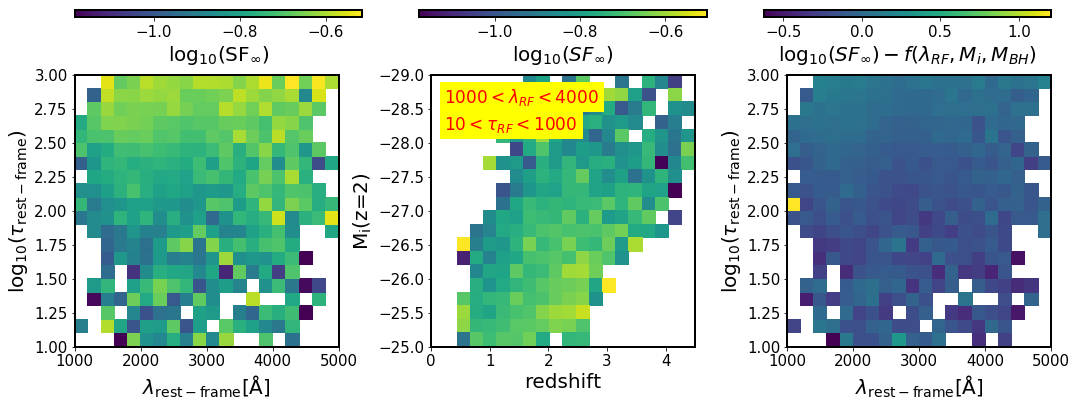

In [135]:

# plot the three panels like Ivezic2004 Fig.1  https://arxiv.org/pdf/astro-ph/0404487.pdf 
# but use tau instead of delta_t ...

fig,ax = plt.subplots(1,3,figsize=(17.5,5))

# left : tau_RF vs lambda_RF  vs SFinf 
logSF = np.log10(np.sqrt(2) *qso['sigmaEXP_sdss-ps1'] )   
logtauRF = np.log10(qso['tauEXP_sdss-ps1']) - np.log10(1.0+qso['REDSHIFT'])
 

X = qso['lambdaRF']
Y = logtauRF
Z = logSF

m_sf = (-1.2 < Z ) & (Z < -0.5)
m = m_sf 

gridsize=20 ; cmap = 'viridis'
bottom, height =  1.04, 0.02
stats_sf =  binned_statistic_2d(X[m],Y[m],Z[m], statistic='median', bins=gridsize, 
                        range = [[1000,5000], [1,3]])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
image = ax[0].pcolormesh(X_,Y_,H , cmap=cmap)
ax[0].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[0].set_ylabel(r'$\log_{10}{(\tau_{\mathrm{rest-frame}})}$')
# get left and right coordinates in figure units 
# for left axis 
l,b,w,h = ax[0].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\log_{10}{(\mathrm{SF}_{\infty})}$')
# middle : M_i  vs  z vs  SFinf   (for a slice in lambdaRF and tauRF)
# start with identical slice as Ivezic 2004 
lmin, lmax = 1000, 4000
tmin, tmax = 10, 1000
m_lambda = (lmin < qso['lambdaRF'] ) & (qso['lambdaRF'] < lmax)
m_tau = (np.log10(tmin) < logtauRF) & (logtauRF  < np.log10(tmax) )

m = m_lambda & m_tau &m_sf
print('lambdaRF and tauRF cut keeps ', np.sum(m),'/' , len(m))

X = qso['REDSHIFT']
Y = qso['MI_Z2']
Z = logSF

stats_sf =  binned_statistic_2d(X[m],Y[m],Z[m], statistic='median', bins=gridsize, 
                        range = [[0,4.5], [-29,-25]])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
image = ax[1].pcolormesh(X_,Y_,H , cmap=cmap)
ax[1].invert_yaxis()
ax[1].set_xlabel('redshift')
ax[1].set_ylabel(r'M$_{\mathrm{i}}$(z=2)')
ax[1].text(0.05,0.9, r'$%d< \lambda_{RF} < %d$'%(lmin,lmax),
          transform=ax[1].transAxes, color='red', fontsize=17,
          backgroundcolor='yellow')
ax[1].text(0.05,0.8, r'$%d< \tau_{RF} < %d$'%(tmin,tmax),
          transform=ax[1].transAxes, color='red', fontsize=17,
          backgroundcolor='yellow')
l,b,w,h = ax[1].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\log_{10}{(SF_{\infty})}$'
            )

# right : tauRF vs lambdaRF vs SFinf - model(Mi, MBH, lambdaRF ) 
X = qso['lambdaRF']
Y = logtauRF
A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297 # for SFinf 
x = np.log10(qso['lambdaRF']/4000)
y = qso['MI_Z2']+23
z = qso['LOGBH'] - 9 
Z = logSF  - A-  B*x - C*y - D*z 
m = m_sf 

stats_sf =  binned_statistic_2d(X[m],Y[m],Z[m], statistic='median', bins=gridsize, 
                        range = [[1000,5000], [1,3]])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
image = ax[2].pcolormesh(X_,Y_,H , cmap=cmap)

l,b,w,h = ax[2].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\log_{10}{(SF_{\infty})} - f(\lambda_{RF}, M_{i}, M_{BH})$'
            )

ax[2].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[2].set_ylabel(r'$\log_{10}{(\tau_{\mathrm{rest-frame}})}$')

fig.subplots_adjust(wspace=0.35)

plt.savefig('Ivezic_2004_Fig_1_SDSS-PS1_tau_sfinf.png', bbox_inches='tight', 
           dpi=100)

In [132]:
binned_statistic_2d?

Do the same but with linear tau,  linear SFinf,  to be even more similar 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


lambdaRF and tauRF cut keeps  7509 / 8516


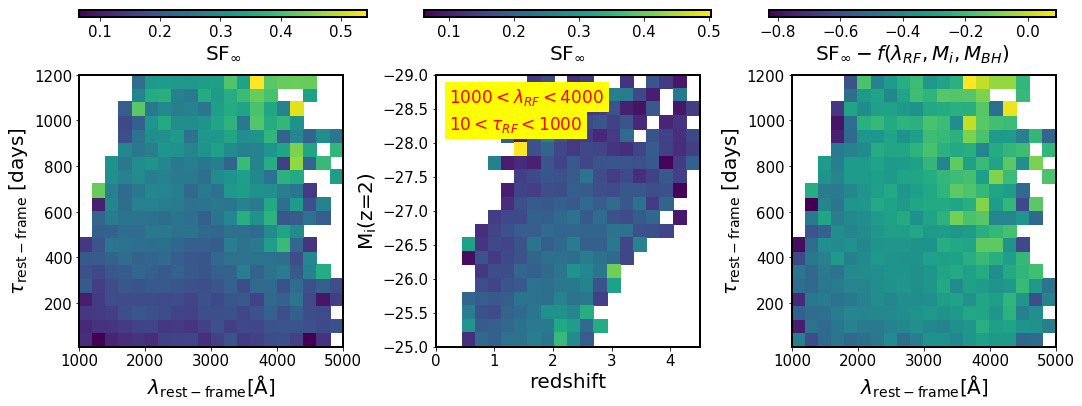

In [136]:
from scipy.stats import binned_statistic_2d
# plot the three panels like Ivezic2004 Fig.1  https://arxiv.org/pdf/astro-ph/0404487.pdf 
# but use tau instead of delta_t ...

fig,ax = plt.subplots(1,3,figsize=(17.5,5))

# left : tau_RF vs lambda_RF  vs SFinf 
#logSF = np.log10(np.sqrt(2) *qso['sigmaEXP_sdss-ps1'] )   
#logtauRF = np.log10(qso['tauEXP_sdss-ps1']) - np.log10(1.0+qso['REDSHIFT'])
SF  = np.sqrt(2) *qso['sigmaEXP_sdss-ps1'] 
tauRF =  qso['tauEXP_sdss-ps1']  / (1.0+qso['REDSHIFT'])

X = qso['lambdaRF']
Y = tauRF
Z = SF

gridsize=20 ; cmap = 'viridis'
bottom, height =  1.04, 0.02
lambdaLims = [1000,5000]
tauLims = [10,1200]
stats_sf =  binned_statistic_2d(X,Y,Z, statistic='median', bins=gridsize, 
                        range = [lambdaLims, tauLims])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
image = ax[0].pcolormesh(X_,Y_,H , cmap=cmap)
ax[0].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[0].set_ylabel(r'$\tau_{\mathrm{rest-frame}}$ [days]')
# get left and right coordinates in figure units 
# for left axis 
l,b,w,h = ax[0].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\mathrm{SF}_{\infty}$')
# middle : M_i  vs  z vs  SFinf   (for a slice in lambdaRF and tauRF)
# start with identical slice as Ivezic 2004 
lmin, lmax = 1000, 4000
tmin, tmax = 10, 1000
m_lambda = (lmin < qso['lambdaRF'] ) & (qso['lambdaRF'] < lmax)
m_tau = (np.log10(tmin) < logtauRF) & (logtauRF  < np.log10(tmax) )

m = m_lambda & m_tau 
print('lambdaRF and tauRF cut keeps ', np.sum(m),'/' , len(m))

X = qso['REDSHIFT']
Y = qso['MI_Z2']
Z = SF

stats_sf =  binned_statistic_2d(X[m],Y[m],Z[m], statistic='median', bins=gridsize, 
                        range = [[0,4.5], [-29,-25]])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
image = ax[1].pcolormesh(X_,Y_,H , cmap=cmap)
ax[1].invert_yaxis()
ax[1].set_xlabel('redshift')
ax[1].set_ylabel(r'M$_{\mathrm{i}}$(z=2)')
ax[1].text(0.05,0.9, r'$%d< \lambda_{RF} < %d$'%(lmin,lmax),
          transform=ax[1].transAxes, color='red', fontsize=17,
          backgroundcolor='yellow')
ax[1].text(0.05,0.8, r'$%d< \tau_{RF} < %d$'%(tmin,tmax),
          transform=ax[1].transAxes, color='red', fontsize=17,
          backgroundcolor='yellow')
l,b,w,h = ax[1].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\mathrm{SF}_{\infty}$'
            )

# right : tauRF vs lambdaRF vs SFinf - model(Mi, MBH, lambdaRF ) 
X = qso['lambdaRF']
Y = tauRF
A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297 # for SFinf 
x = np.log10(qso['lambdaRF']/4000)
y = qso['MI_Z2']+23
z = qso['LOGBH'] - 9 
Z = SF  - np.power(10, A-  B*x - C*y - D*z) 


stats_sf =  binned_statistic_2d(X,Y,Z, statistic='median', bins=gridsize, 
                        range = [lambdaLims, tauLims])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
image = ax[2].pcolormesh(X_,Y_,H , cmap=cmap)

l,b,w,h = ax[2].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\mathrm{SF}_{\infty} - f(\lambda_{RF}, M_{i}, M_{BH})$'
            )

ax[2].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[2].set_ylabel(r'$\tau_{\mathrm{rest-frame}}$ [days]')

fig.subplots_adjust(wspace=0.35)

plt.savefig('Ivezic_2004_Fig_1_SDSS-PS1_tau_sfinf_lin.png', bbox_inches='tight', 
           dpi=100)

Collapse the y-axis of third panel: calculate median(SF_inf - model), and rms for errors, across tau_RF ... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


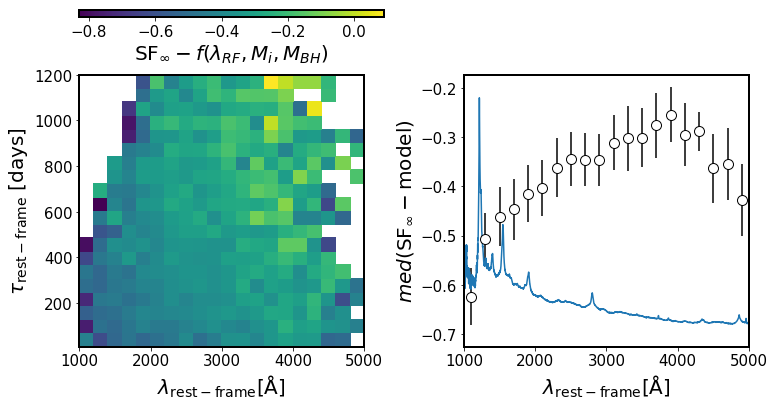

In [196]:
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic
# plot the three panels like Ivezic2004 Fig.1  https://arxiv.org/pdf/astro-ph/0404487.pdf 
# but use tau instead of delta_t ...

fig,ax = plt.subplots(1,2,figsize=(12,5))

SF  = np.sqrt(2) *qso['sigmaEXP_sdss-ps1'] 
tauRF =  qso['tauEXP_sdss-ps1']  / (1.0+qso['REDSHIFT'])

gridsize=20 ; cmap = 'viridis'
bottom, height =  1.04, 0.02
lambdaLims = [1000,5000]
tauLims = [10,1200]


# right : tauRF vs lambdaRF vs SFinf - model(Mi, MBH, lambdaRF ) 
X = qso['lambdaRF']
Y = tauRF
A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297 # for SFinf 
x = np.log10(qso['lambdaRF']/4000)
y = qso['MI_Z2']+23
z = qso['LOGBH'] - 9 
Z = SF  - np.power(10, A-  B*x - C*y - D*z) 

stats_sf =  binned_statistic_2d(X,Y,Z, statistic='median', bins=gridsize, 
                        range = [lambdaLims, tauLims])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
iax = 0
image = ax[iax].pcolormesh(X_,Y_,H , cmap=cmap)

l,b,w,h = ax[iax].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\mathrm{SF}_{\infty} - f(\lambda_{RF}, M_{i}, M_{BH})$'
            )

ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[iax].set_ylabel(r'$\tau_{\mathrm{rest-frame}}$ [days]')


# calculate median (SF - model(M_i, M_BH, lambda))  , rms along y : collapse 
# as a function of lambda 

stat_med, bin_edges,  binnumber = binned_statistic(X,Z,statistic='median', 
                                                    bins=xedges)
bin_centers = (bin_edges[1:] + bin_edges[:-1] ) /2.


# get the count per bin
stat_count, bin_edges,  binnumber = bs(X,Z,statistic='count', bins=xedges)
N = stat_count[0]

# get the RMS, estimated by sigmaG,  per bin 
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
stat_RMS, bin_edges,  binnumber = bs(X,Z,statistic=sigmaG, bins=xedges)

sigma_median = 1.25 * stat_RMS / np.sqrt(N)

iax = 1 
ax[iax].errorbar(bin_centers, stat_med, sigma_median, fmt='o', 
            mec = 'black', mfc='white', ecolor = 'black', capthick=2,
            markersize=10, )

ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[iax].set_ylabel(r'$med(\mathrm{SF}_{\infty}-$model)')
fig.subplots_adjust(wspace=0.35)

# overplot mean QSO  BOSS spectrum from 
# Harris2016 https://arxiv.org/abs/1603.08626
# https://data.sdss.org/sas/dr12/boss/qso/composite/

# better : VandenBerk2001, because it covers the entire range 
# https://iopscience.iop.org/article/10.1086/321167/fulltext/
qso_van = Table.read('vandenberk_2001_Tab1.txt', format='ascii', 
                     names=['lambda', 'flux', 'fluxErr'])
ax[iax].plot(qso_van['lambda'], qso_van['flux']/45 - 0.7 )
ax[iax].set_xlim(lambdaLims)
plt.savefig('Ivezic_2004_Fig_1_SDSS-PS1_third_panel_linear.png', bbox_inches='tight', 
           dpi=100)

Instead of calculating median on SF-model aggregated in bins of $\lambda$ across $\tau$, get the medians on the actual pixels above, so that for the errorbars N=20...( however many pixels we have vertically)... 

In [13]:
# Read the Celerite results joined on dbID  to DBQSO  - thus it has DR7 data 
#celerite  = Table.read("190409_Celerite_real_Jeff1_radec.txt", format='ascii')
celerite  = Table.read("190807_Celerite_real_Jeff1_radec.txt", format='ascii')
print(len(celerite))
# Add Shen2011
cat = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGLBOL_ERR','LOGL_MGII','LOGL_MGII_ERR','FWHM_MGII',
        'FWHM_MGII_ERR','EW_MGII', 'EW_MGII_ERR',    
        'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]

# crossmatch 
cat1 = SkyCoord(ra=celerite['ra']*u.degree, 
                dec=celerite['dec']*u.degree)
cat2 = SkyCoord(ra=shen2011['RA']*u.degree,
                dec=shen2011['DEC']*u.degree, frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
qso = hstack([celerite, shen2011[idx]])
qso['d2d'] = sep2d.arcsecond
qso.remove_rows(qso['d2d']>1)
print(len(qso))

8516
8513


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


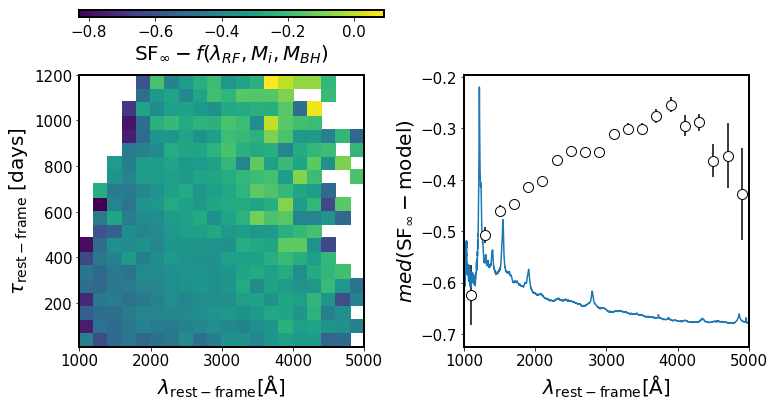

In [122]:
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic
# plot the three panels like Ivezic2004 Fig.1  https://arxiv.org/pdf/astro-ph/0404487.pdf 
# but use tau instead of delta_t ...

fig,ax = plt.subplots(1,2,figsize=(12,5))

SF  = np.sqrt(2) *qso['sigmaEXP_sdss-ps1'] 
tauRF =  qso['tauEXP_sdss-ps1']  / (1.0+qso['REDSHIFT'])

gridsize=20 ; cmap = 'viridis'
bottom, height =  1.04, 0.02
lambdaLims = [1000,5000]
tauLims = [10,1200]


# add column with lambdaRF 
lambdaobs = 6250 
qso['lambdaRF'] = lambdaobs /  (1.+qso['REDSHIFT'])

# right : tauRF vs lambdaRF vs SFinf - model(Mi, MBH, lambdaRF ) 
X = qso['lambdaRF']
Y = tauRF
A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297 # for SFinf 
x = np.log10(qso['lambdaRF']/4000)
y = qso['MI_Z2']+23
z = qso['LOGBH'] - 9 
Z = SF  - np.power(10, A-  B*x - C*y - D*z) 

stats_sf =  binned_statistic_2d(X,Y,Z, statistic='median', bins=gridsize, 
                        range = [lambdaLims, tauLims])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X_,Y_ = np.meshgrid(xedges, yedges)
iax = 0
image = ax[iax].pcolormesh(X_,Y_,H , cmap=cmap)

l,b,w,h = ax[iax].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\mathrm{SF}_{\infty} - f(\lambda_{RF}, M_{i}, M_{BH})$'
            )

ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[iax].set_ylabel(r'$\tau_{\mathrm{rest-frame}}$ [days]')


# calculate median (SF - model(M_i, M_BH, lambda))  , rms along y : collapse 
# as a function of lambda 
stat_med, bin_edges,  binnumber = binned_statistic(X,Z,statistic='median', 
                                                    bins=xedges)
bin_centers = (bin_edges[1:] + bin_edges[:-1] ) /2.


# get the count per bin
stat_count, bin_edges,  binnumber = bs(X,Z,statistic='count', bins=xedges)
N = stat_count

# get the RMS, estimated by sigmaG,  per bin 
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
stat_RMS, bin_edges,  binnumber = bs(X,Z,statistic=sigmaG, bins=xedges)

sigma_median = 1.25 * stat_RMS / np.sqrt(N)
#stat_RMSa = stat_RMS
iax = 1 
ax[iax].errorbar(bin_centers, stat_med, sigma_median, fmt='o', 
            mec = 'black', mfc='white', ecolor = 'black', capthick=2,
            markersize=10, )

ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[iax].set_ylabel(r'$med(\mathrm{SF}_{\infty}-$model)')
fig.subplots_adjust(wspace=0.35)

# overplot mean QSO  BOSS spectrum from 
# Harris2016 https://arxiv.org/abs/1603.08626
# https://data.sdss.org/sas/dr12/boss/qso/composite/

# better : VandenBerk2001, because it covers the entire range 
# https://iopscience.iop.org/article/10.1086/321167/fulltext/
qso_van = Table.read('vandenberk_2001_Tab1.txt', format='ascii', 
                     names=['lambda', 'flux', 'fluxErr'])
ax[iax].plot(qso_van['lambda'], qso_van['flux']/45 - 0.7 )
ax[iax].set_xlim(lambdaLims)
plt.savefig('Ivezic_2004_Fig_1_SDSS-PS1_third_panel_linear.png', bbox_inches='tight', 
           dpi=100)


In [ ]:
stat_RMS

-0.5425504937284109 -0.479 0.12546597145850893 0.10362488999283885
Using ver= 1
6371


In [188]:
seg

'sdss-ps1'

## Production : Fig. 26 (SF - model residuals) <a id='Fig26'></a>

In [231]:
def plot_SF_residuals(qso, ver='1', source='S19, SDSS-PS1', 
                     rhs_title= None):
    ''' A quick convenience function to plot SF 
    residuals, i.e.  
    SF -  model(SF),   where model is 
    Eq. 11 in S19 : 
    log(f) = A + B * log(lambdaRF/4000) + C * (M_i+23) + D* log(M_BH/10^9),
    so it's SF  - log(SF), for A,C,D, 
    given by the fit. 
    
    We fitted either only those quasars that had SDSS-PS1 data 
    AND had good fit results from M10 ("v1"), 
    
    or all quasars with SDSS-PS1 data. 
    
    Thus the parameters are:
    ------------
    ver = 1, or 2  (string)
    source = 'S19, SDSS'  (or SDSS-PS1,  string )
    
    '''
    fig,ax = plt.subplots(1,2,figsize=(11,5))
    # read in the IDL fit results 
    #ver = '1' # is for 6371 QSO, only those that have M10 matches 
    #source  = 'S19, SDSS-PS1' # or 'S19,SDSS-PS1' 
    seg = source[len('S19, '):].lower()
    par = 'SF' # parameter for which we plot the residuals... 
    coeffs = Table.read('Table2_IDL_fit_results_190807_v'+ver+'.txt', 
                        format='ascii')
    row = ( coeffs['f'] == par ) & (coeffs['source'] == source )
    #print(coeffs[row])
    A,B,C,D = coeffs[row]['A'][0],coeffs[row]['B'][0], \
              coeffs[row]['C'][0],coeffs[row]['D'][0]
    print(A,B,C,D)
    print('Using ver=',ver)

    # read in the quasar data 
    if ver =='1':
        # 
        # For  r  band starting with  9258
        # Npts>10  9139
        # Plike - Pnoise  > 2  9128
        # Plike - Pinf > 0.05   7103
        # edge == 0   7823
        # Combined kept :  6871

        # and of these , 6371 have SDSS-PS1 data . 
        # 
        qso = Table.read('190807_Celerite_real_Jeff1_Shen2008-2011_s82r_only_IDL.txt',
                         format='ascii')
        print(len(qso))
        title= 'M10 subset, '+str(len(qso)) + '/8516'

    if ver =='2':
        # using all 8513 quasars that have SDSS-PS1 data 
        qso = Table.read('190807_Celerite_real_Jeff1_Shen2008-2011_IDL.txt', 
                         format='ascii')
        print(len(qso))
        title= 'all 8516 quasars'

                      
    SF  = np.sqrt(2) *qso['sigmaEXP_'+seg] 
    tauRF =  qso['tauEXP_'+seg]  / (1.0+qso['REDSHIFT'])

    gridsize=20 ; cmap = 'viridis'
    bottom, height =  1.04, 0.02
    lambdaLims = [1000,5000]
    tauLims = [10,1200]


    # add column with lambdaRF 
    lambdaobs = 6250 
    qso['lambdaRF'] = lambdaobs /  (1.+qso['REDSHIFT'])

    # right : tauRF vs lambdaRF vs SFinf - model(Mi, MBH, lambdaRF ) 
    x = qso['lambdaRF']
    y = tauRF
    #A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297 # for SFinf 
    x_lambda = np.log10(qso['lambdaRF']/4000)
    y_mi = qso['MI_Z2']+23
    z_mbh = qso['LOGBH'] - 9 
    # calculate the residuals 
    z = SF  - np.power(10, A-  B*x_lambda - C*y_mi - D*z_mbh) 

    # remove extremes...
    mask = (-1<z)&(z< 0.25)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    stats_sf =  binned_statistic_2d(x,y,z, statistic='median', bins=gridsize, 
                            range = [lambdaLims, tauLims])
    H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
    X,Y = np.meshgrid(xedges[:-1], yedges[:-1])
    iax = 0
    image = ax[iax].pcolormesh(X,Y,H , cmap=cmap)

    l,b,w,h = ax[iax].get_position().bounds
    cax = fig.add_axes([l,bottom,w,height])
    plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
                 label=r'$\mathrm{SF}_{\infty} - f(\lambda_{RF}, M_{i}, M_{BH})$'
                )
    ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
    ax[iax].set_ylabel(r'$\tau_{\mathrm{rest-frame}}$ [days]')


    dX = xedges[1]-xedges[0]
    XC = X+dX/2

    dY = yedges[1]-yedges[0]
    YC = Y+dY/2 

    #sel = (xedges[0] < X ) & (X < xedges[2])
    #ax[iax].scatter(XC[sel], YC[sel], marker='x', s=40,c='red')


    ms = 6 # set markersize
    results = {} # store results 
    ##############################
    # stats on medians data 
    ############################
    sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))

    stats_med_data = True 
    if stats_med_data : 
        # mark those within certain bins 
        #X_ = X[:-1]
        hf = H.flatten()
        xf = XC.flatten()

        sel = ~np.isnan(hf)

        stat_med, bin_edges,  binnumber = bs(xf[sel],hf[sel],
                                               statistic='median', bins=xedges)
        stat_RMS, bin_edges,  binnumber = bs(xf[sel],hf[sel],
                                               statistic=sigmaG, bins=xedges)
        stat_count, bin_edges, binnumber = bs(xf[sel],hf[sel], 
                                               statistic='count', bins=xedges)
        bin_centers = (bin_edges[1:] + bin_edges[:-1] ) /2.


        N = stat_count
        sigma_median = 1.25 * stat_RMS / np.sqrt(N)

        iax = 1 
        ax[iax].errorbar(bin_centers, stat_med, sigma_median, fmt='o', 
                    mec = 'black', mfc='white', ecolor = 'black', capthick=2,
                    markersize=ms, label='median')
        post = 'med'
        results['median'] = {'median':stat_med, 'rms':stat_RMS, 'N':stat_count, 
                             'bin_centers':bin_centers}

    ###################################
    # stats on raw data 
    ###################################
    stats_raw_data = True 
    if stats_raw_data :

        stat_med, bin_edges,  binnumber = bs(x,z,statistic='median', 
                                                            bins=xedges)
        stat_RMS, bin_edges,  binnumber = bs(x,z,statistic=sigmaG, bins=xedges)
        stat_count, bin_edges,  binnumber = bs(x,z,statistic='count', bins=xedges)


        bin_centers = (bin_edges[1:] + bin_edges[:-1] ) /2.
        N = stat_count
        sigma_median = 1.25 * stat_RMS / np.sqrt(N)
        iax = 1 
        ax[iax].errorbar(bin_centers,stat_med, sigma_median, fmt='o',
                         mec = 'blue', mfc='white', 
                         ecolor = 'blue', capthick=2, markersize=ms, 
                        label='raw')

        post = 'raw'
        results['raw'] = {'median':stat_med, 'rms':stat_RMS, 'N':stat_count, 
                            'bin_centers':bin_centers}

    ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
    ax[iax].set_ylabel(r'$med(\mathrm{SF}_{\infty}-$model)')
    ax[iax].legend(loc='upper left')
    fig.subplots_adjust(wspace=0.35)

    # overplot mean QSO  BOSS spectrum from 
    # Harris2016 https://arxiv.org/abs/1603.08626
    # https://data.sdss.org/sas/dr12/boss/qso/composite/

    # better : VandenBerk2001, because it covers the entire range 
    # https://iopscience.iop.org/article/10.1086/321167/fulltext/
    qso_van = Table.read('vandenberk_2001_Tab1.txt', format='ascii', 
                         names=['lambda', 'flux', 'fluxErr'])
    ax[iax].plot(qso_van['lambda'], qso_van['flux']/45 - 0.7 )
    ax[iax].set_xlim(lambdaLims)
    if rhs_title:
        ax[iax].set_title(rhs_title)
    else : # the default title: whether using SDSS or SDSS-PS1 quasars,
           # and which subset of quasars (M10 6371: v1,  
           # or all 8516 quasars: v2 )
        ax[iax].set_title(source + ', v'+ver+',\n '+title)
    figname = 'Ivezic_2004_Fig_1_'+seg+'_v'+ver+'.png'
    plt.savefig(figname, 
                bbox_inches='tight', dpi=100)
    print('Saved as %s'%figname)

1 SDSS
-0.5425504937284109 -0.479 0.12546597145850893 0.10362488999283885
Using ver= 1
6371


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

Saved as Ivezic_2004_Fig_1_sdss_v1.png
1 SDSS-PS1
-0.4755806735381703 -0.479 0.11757886788175752 0.11753837793751368
Using ver= 1
6371


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Saved as Ivezic_2004_Fig_1_sdss-ps1_v1.png
2 SDSS
-0.5081795908050281 -0.479 0.12239291603219263 0.12368886917936651
Using ver= 2
8516


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Saved as Ivezic_2004_Fig_1_sdss_v2.png
2 SDSS-PS1
-0.4484437196418946 -0.479 0.11724561021378108 0.12975366983672568
Using ver= 2
8516


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Saved as Ivezic_2004_Fig_1_sdss-ps1_v2.png


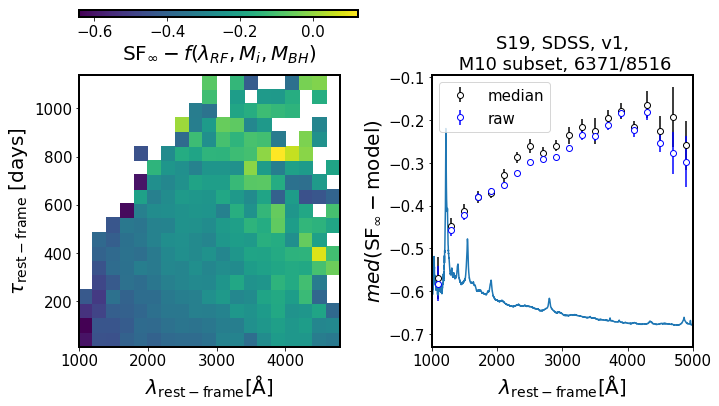

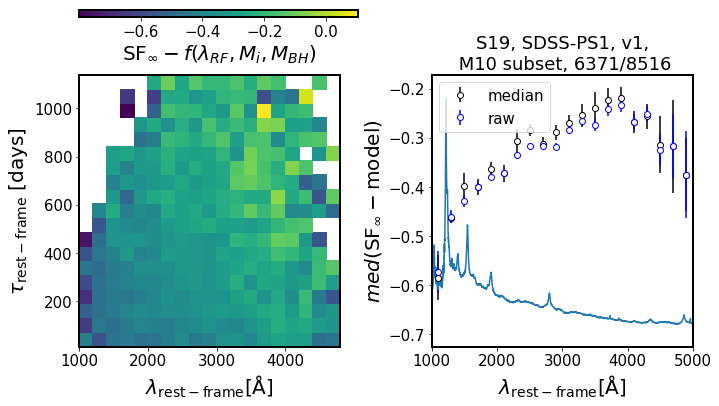

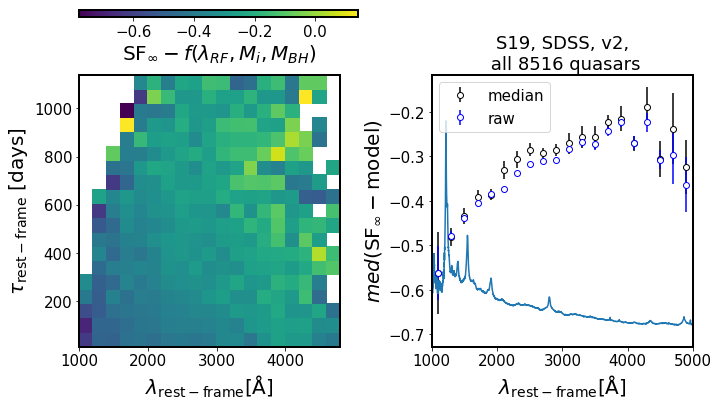

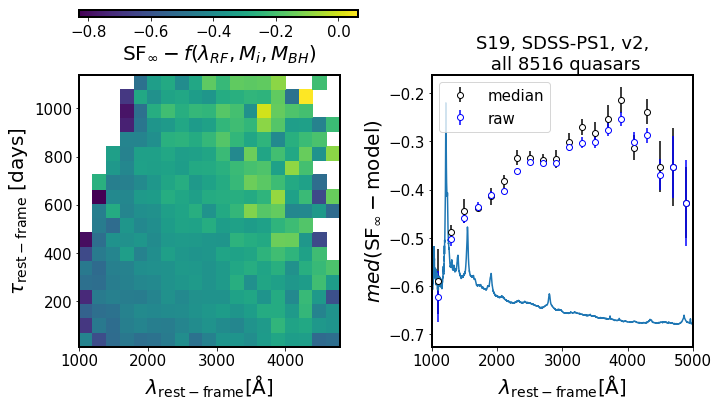

In [230]:
import itertools
for ver, seg in itertools.product('12',['SDSS','SDSS-PS1']):
    print(ver,seg)
    plot_SF_residuals(qso, ver=ver, source='S19, '+seg)

-0.4484437196418946 -0.479 0.11724561021378108 0.12975366983672568
Using ver= 2
8516


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

Saved as Ivezic_2004_Fig_1_sdss-ps1_v2.png


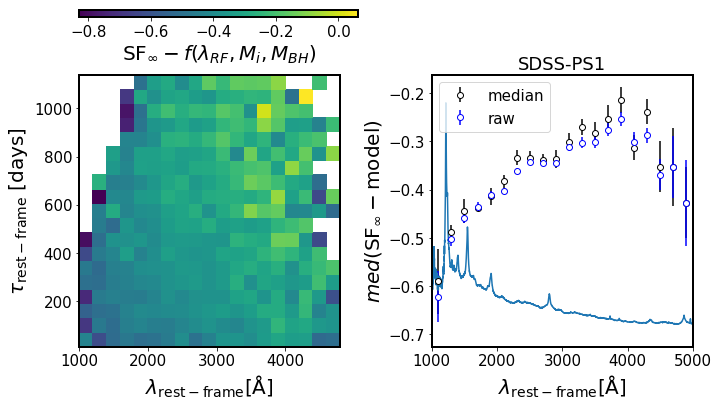

In [233]:
plot_SF_residuals(qso, ver='2', source='S19, SDSS-PS1', rhs_title='SDSS-PS1')

In [218]:

for a,b in itertools.product('AB','12'):
    print(a,b)


A 1
A 2
B 1
B 2


raw blue
median black


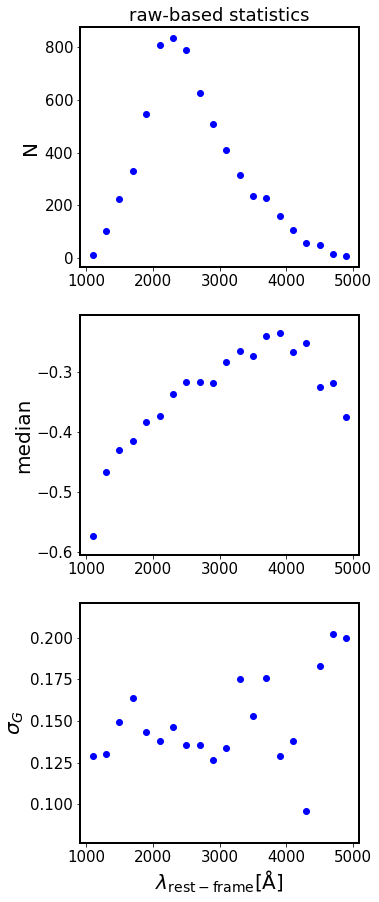

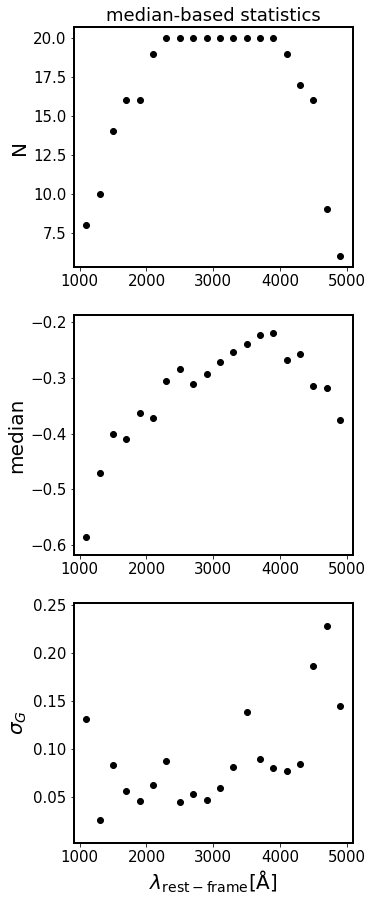

In [192]:

for key, color in zip(['raw','median'], ['blue','black']):
    print(key, color )
    fig,ax = plt.subplots(3,1, figsize=(5,15))
    ax[0].set_title(key+'-based statistics')
    x = results[key]['bin_centers']
    ax[0].scatter(x, results[key]['N'], c=color)
    ax[0].set_ylabel('N')

    ax[1].scatter(x,results[key]['median'],c=color)
    ax[1].set_ylabel('median')

    ax[2].scatter(x,results[key]['rms'],c=color)
    ax[2].set_ylabel(r'$\sigma_{G}$')
    ax[2].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
    fname =  'Ivezic_2004_Fig_1_'+seg+'_v'+ver+'_stats.png'
    #plt.savefig('Ivezic_2004_Fig_1_SDSS-PS1_third_panel_linear_'+key+'stats.png',
    #           bbox_inches='tight')
    plt.savefig(fname, bbox_inches='tight', dpi=100)

Experiment : why are the residuals negative ? 

-0.4755806735381703 -0.479 0.11757886788175752 0.11753837793751368
Using ver= 1
6371


<ipython-input-20-54bde4c2c9d1>:94: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  image = ax[iax].pcolormesh(X,Y,H , cmap=cmap,linewidth=0,rasterized=True)


(-0.0573487970392878, 0.09833315509587064)
0.15568195213515845
21.601


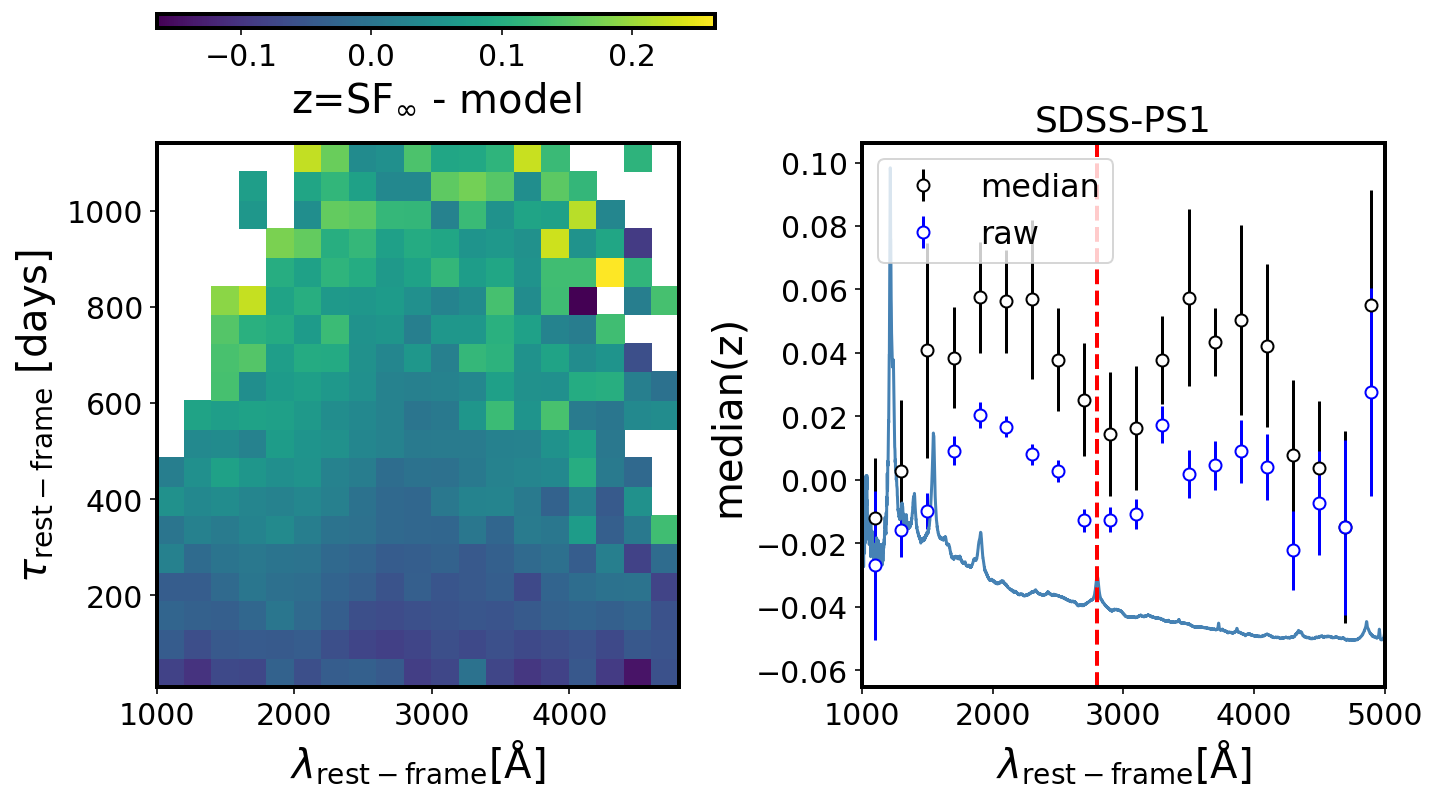

In [20]:
%matplotlib inline
ver='1'
source='S19, SDSS-PS1' 
rhs_title= 'SDSS-PS1'

fig,ax = plt.subplots(1,2,figsize=(11,5))
# read in the IDL fit results 
#ver = '1' # is for 6371 QSO, only those that have M10 matches 
#source  = 'S19, SDSS-PS1' # or 'S19,SDSS-PS1' 
seg = source[len('S19, '):].lower()
par = 'SF' # parameter for which we plot the residuals... 
coeffs = Table.read('../code2/Table2_IDL_fit_results_190807_v'+ver+'.txt', 
                    format='ascii')
row = ( coeffs['f'] == par ) & (coeffs['source'] == source )
#print(coeffs[row])
A,B,C,D = coeffs[row]['A'][0],coeffs[row]['B'][0], \
          coeffs[row]['C'][0],coeffs[row]['D'][0]
print(A,B,C,D)
print('Using ver=',ver)

# read in the quasar data 
if ver =='1':
    # 
    # For  r  band starting with  9258
    # Npts>10  9139
    # Plike - Pnoise  > 2  9128
    # Plike - Pinf > 0.05   7103
    # edge == 0   7823
    # Combined kept :  6871

    # and of these , 6371 have SDSS-PS1 data . 
    # 
    qso = Table.read('../code2/190807_Celerite_real_Jeff1_Shen2008-2011_s82r_only_IDL.txt',
                     format='ascii')
    print(len(qso))
    title= 'M10 subset, '+str(len(qso)) + '/8516'

if ver =='2':
    # using all 8513 quasars that have SDSS-PS1 data 
    qso = Table.read('190807_Celerite_real_Jeff1_Shen2008-2011_IDL.txt', 
                     format='ascii')
    print(len(qso))
    title= 'all 8516 quasars'


SF  = np.sqrt(2) *qso['sigmaEXP_'+seg].data
tauRF =  qso['tauEXP_'+seg].data  / (1.0+qso['REDSHIFT'].data)

gridsize=20 ; cmap = 'viridis'
bottom, height =  1.04, 0.02
lambdaLims = [1000,5000]
tauLims = [10,1200]


# add column with lambdaRF 
lambdaobs = 6250 
qso['lambdaRF'] = lambdaobs /  (1.+qso['REDSHIFT'].data)

# right : tauRF vs lambdaRF vs SFinf - model(Mi, MBH, lambdaRF ) 
x = qso['lambdaRF'].data
y = tauRF
#A = -0.448 ; B = -0.479 ; C = 0.1172 ; D  = 0.1297 # for SFinf 
x_lambda = np.log10(qso['lambdaRF'].data/4000)
y_mi = qso['MI_Z2'].data+23
z_mbh = qso['LOGBH'].data - 9 
# calculate the residuals 
model =  np.power(10, A+  B*x_lambda + C*y_mi + D*z_mbh) 

divideByModel = False 
if divideByModel : 
    z = (SF-model) / model
    mask = (-1<z)&(z< 1.5)
    cbar_label  = r'z=($\mathrm{SF}_{\infty}$' +' - model) / model'
    post = 'div'
else : 
    z = SF  - model
    mask = (-.2<z)&(z< 0.3)
    cbar_label  = r'z=$\mathrm{SF}_{\infty}$' +' - model'
    post = ''
    
#remove extremes...
x = x[mask]
y = y[mask]
z = z[mask]

# calculate the left-hand side plot statistics 
stats_sf =  binned_statistic_2d(x,y,z, statistic='median', bins=gridsize, 
                        range = [lambdaLims, tauLims])
H ,xedges, yedges= stats_sf[0].T , stats_sf[1], stats_sf[2]
X,Y = np.meshgrid(xedges[:-1], yedges[:-1])

# plotting the left 
iax = 0
image = ax[iax].pcolormesh(X,Y,H , cmap=cmap,linewidth=0,rasterized=True)

l,b,w,h = ax[iax].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])

#cbar_label = r'$\mathrm{SF}_{\infty} - f(\lambda_{RF}, M_{i}, M_{BH})$'
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=cbar_label
            )
ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
ax[iax].set_ylabel(r'$\tau_{\mathrm{rest-frame}}$ [days]')

dX = xedges[1]-xedges[0]
XC = X+dX/2

dY = yedges[1]-yedges[0]
YC = Y+dY/2 

#sel = (xedges[0] < X ) & (X < xedges[2])
#ax[iax].scatter(XC[sel], YC[sel], marker='x', s=40,c='red')


ms = 6 # set markersize
results = {} # store results 
##############################
# stats on medians data 
############################
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))

stats_med_data = True 
if stats_med_data : 
    # mark those within certain bins 
    #X_ = X[:-1]
    hf = H.flatten()
    xf = XC.flatten()

    sel = ~np.isnan(hf)

    stat_med, bin_edges,  binnumber = bs(xf[sel],hf[sel],
                                           statistic='median', bins=xedges)
    stat_RMS, bin_edges,  binnumber = bs(xf[sel],hf[sel],
                                           statistic=sigmaG, bins=xedges)
    stat_count, bin_edges, binnumber = bs(xf[sel],hf[sel], 
                                           statistic='count', bins=xedges)
    bin_centers = (bin_edges[1:] + bin_edges[:-1] ) /2.


    N = stat_count
    sigma_median = 1.25 * stat_RMS / np.sqrt(N)

    iax = 1 
    ax[iax].errorbar(bin_centers, stat_med, sigma_median, fmt='o', 
                mec = 'black', mfc='white', ecolor = 'black', capthick=2,
                markersize=ms, label='median')
    results['median'] = {'median':stat_med, 'rms':stat_RMS, 'N':stat_count, 
                         'bin_centers':bin_centers}

###################################
# stats on raw data 
###################################
stats_raw_data = True 
if stats_raw_data :
    stat_med, bin_edges,  binnumber = bs(x,z,statistic='median', 
                                                        bins=xedges)
    stat_RMS, bin_edges,  binnumber = bs(x,z,statistic=sigmaG, bins=xedges)
    stat_count, bin_edges,  binnumber = bs(x,z,statistic='count', bins=xedges)


    bin_centers = (bin_edges[1:] + bin_edges[:-1] ) /2.
    N = stat_count
    sigma_median = 1.25 * stat_RMS / np.sqrt(N)
    iax = 1 
    ax[iax].errorbar(bin_centers,stat_med, sigma_median, fmt='o',
                     mec = 'blue', mfc='white', 
                     ecolor = 'blue', capthick=2, markersize=ms, 
                    label='raw')
    results['raw'] = {'median':stat_med, 'rms':stat_RMS, 'N':stat_count, 
                        'bin_centers':bin_centers}
iax = 1 
ax[iax].set_xlabel(r'$\lambda_{\mathrm{rest-frame}} [\mathrm{\AA}]$')
r'$med(\mathrm{SF}_{\infty}-$model)'
ax[iax].set_ylabel('median(z)')
ax[iax].legend(loc='upper left', fontsize=16)
fig.subplots_adjust(wspace=0.35)

# overplot mean QSO  BOSS spectrum from 
# Harris2016 https://arxiv.org/abs/1603.08626
# https://data.sdss.org/sas/dr12/boss/qso/composite/

# better : VandenBerk2001, because it covers the entire range 
# https://iopscience.iop.org/article/10.1086/321167/fulltext/
qso_van = Table.read('../code2/vandenberk_2001_Tab1.txt', format='ascii', 
                     names=['lambda', 'flux', 'fluxErr'])
iax = 1 
# figure out the offset and scale ... 
ylims = ax[iax].get_ylim()
print(ylims)
yrange = max(ylims) - min(ylims)
print(yrange)
frange = max(qso_van['flux'])  - min(qso_van['flux'])
print(frange)
scale = frange / yrange
shift = min(ylims)

ax[iax].plot(qso_van['lambda'],(qso_van['flux']/scale)+shift,c='steelblue' )
ax[iax].axvline(2800,ls='--',lw=2,c='r')
ax[iax].set_xlim(lambdaLims)
if rhs_title:
    ax[iax].set_title(rhs_title)
else : # the default title: whether using SDSS or SDSS-PS1 quasars,
       # and which subset of quasars (M10 6371: v1,  
       # or all 8516 quasars: v2 )
    ax[iax].set_title(source + ', v'+ver+',\n '+title)
#figname = 'Ivezic_2004_Fig_1_'+seg+'_v'+ver+post+'.pdf'
plt.savefig('fig26.pdf', 
            bbox_inches='tight', dpi=100)
#print('Saved as %s'%figname)

Inspect why raw and median-based aggregates are so differente.... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


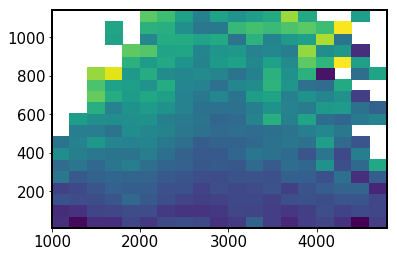

In [218]:
stats_sf =  binned_statistic_2d(x,y,z, statistic='median', bins=gridsize, 
                        range = [lambdaLims, tauLims], expand_binnumbers=True)
H ,xedges, yedges = stats_sf[0].T , stats_sf[1], stats_sf[2]
xcenters = xedges[:-1] + dX/2
X,Y = np.meshgrid(xedges[:-1], yedges[:-1])
dX = xedges[1]-xedges[0]
XC = X+dX/2

# plotting the left 
iax = 0
# select just one column...
mask = XC == 2500

image = plt.pcolormesh(X,Y,H , cmap=cmap)


xBin 0  left edge  1000.0
xBin 0  center  1100.0


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


xBin 1  left edge  1200.0
xBin 1  center  1300.0
xBin 2  left edge  1400.0
xBin 2  center  1500.0
xBin 3  left edge  1600.0
xBin 3  center  1700.0
xBin 4  left edge  1800.0
xBin 4  center  1900.0
xBin 5  left edge  2000.0
xBin 5  center  2100.0
xBin 6  left edge  2200.0
xBin 6  center  2300.0
xBin 7  left edge  2400.0
xBin 7  center  2500.0
xBin 8  left edge  2600.0
xBin 8  center  2700.0
xBin 9  left edge  2800.0
xBin 9  center  2900.0
xBin 10  left edge  3000.0
xBin 10  center  3100.0
xBin 11  left edge  3200.0
xBin 11  center  3300.0
xBin 12  left edge  3400.0
xBin 12  center  3500.0
xBin 13  left edge  3600.0
xBin 13  center  3700.0
xBin 14  left edge  3800.0
xBin 14  center  3900.0
xBin 15  left edge  4000.0
xBin 15  center  4100.0
xBin 16  left edge  4200.0
xBin 16  center  4300.0
xBin 17  left edge  4400.0
xBin 17  center  4500.0
xBin 18  left edge  4600.0
xBin 18  center  4700.0
xBin 19  left edge  4800.0
xBin 19  center  4900.0


IndexError: index 20 is out of bounds for axis 0 with size 20

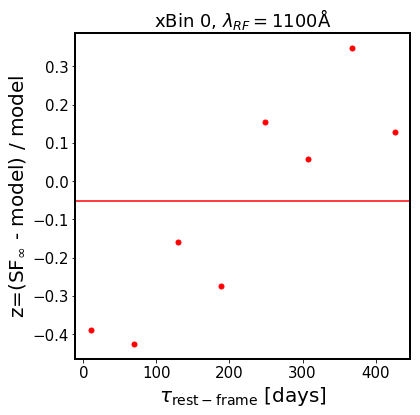

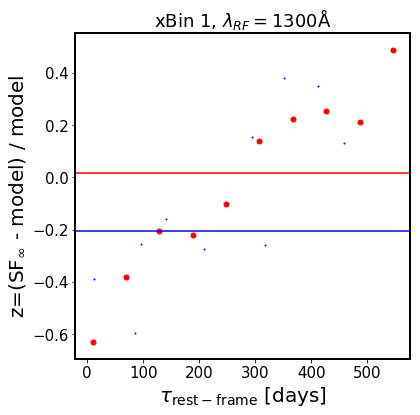

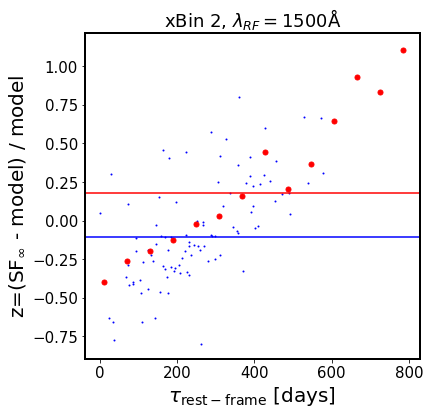

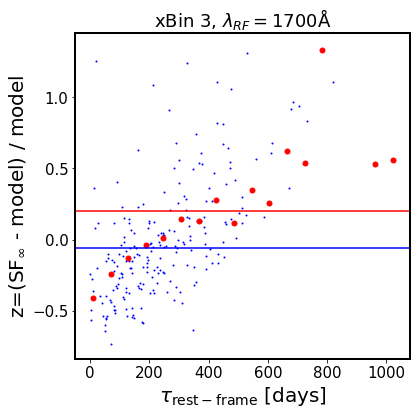

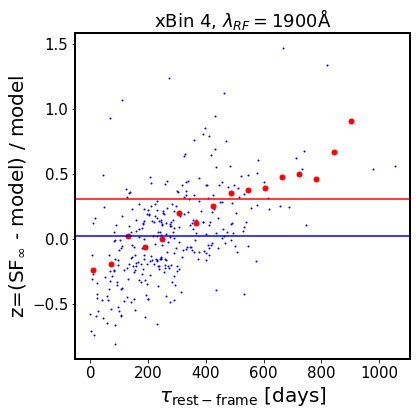

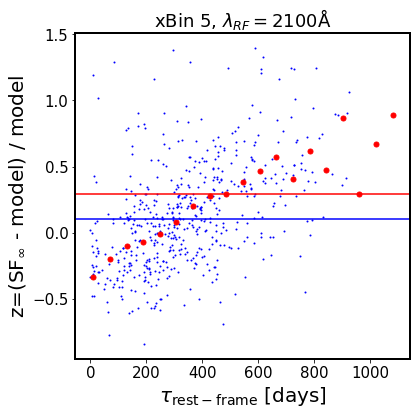

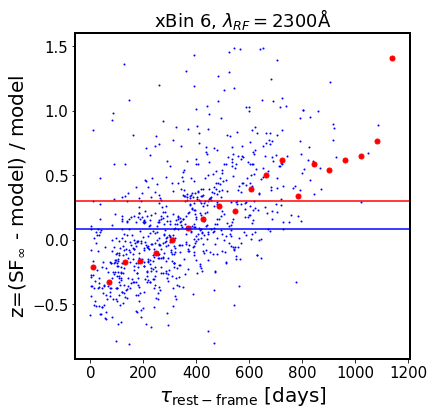

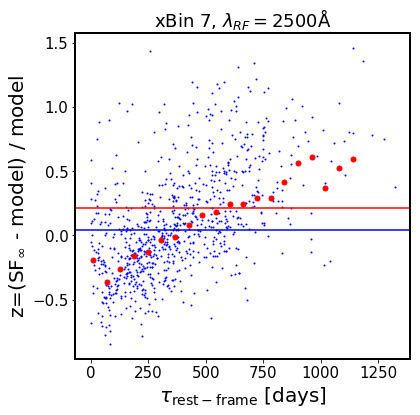

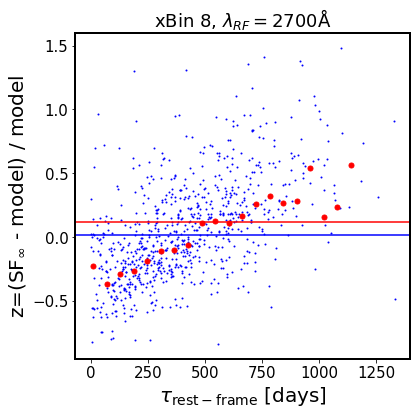

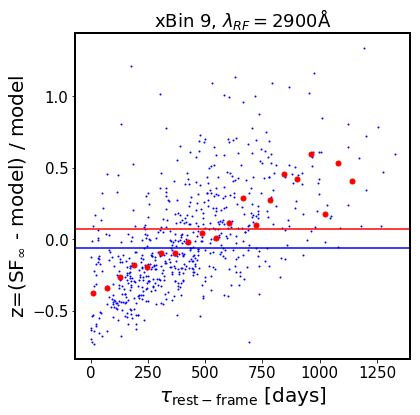

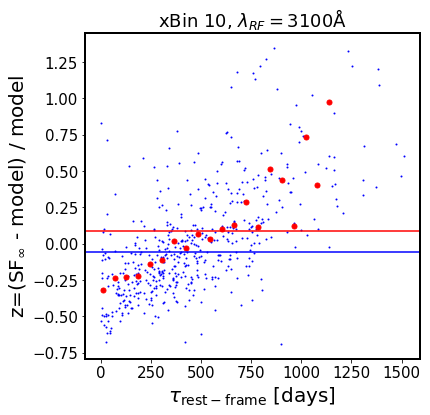

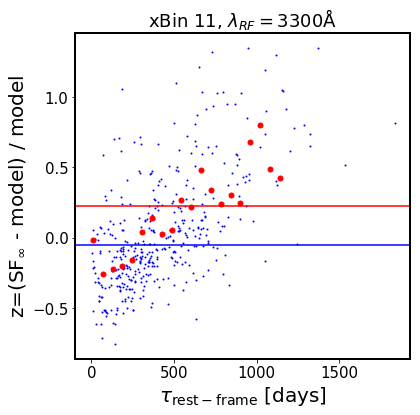

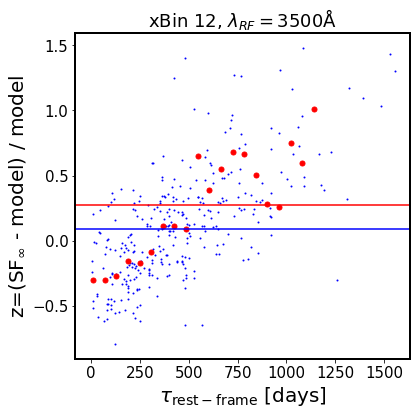

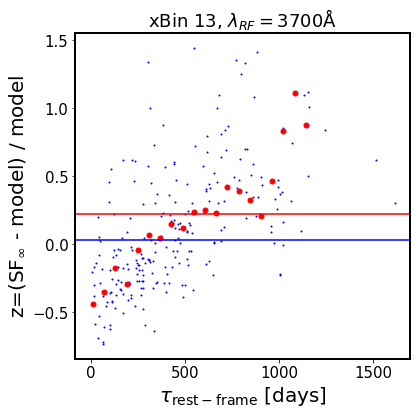

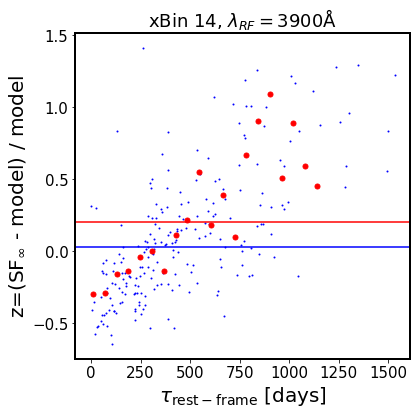

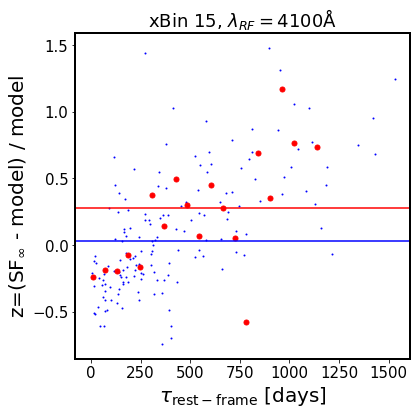

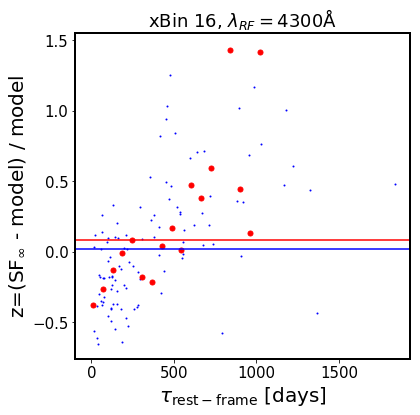

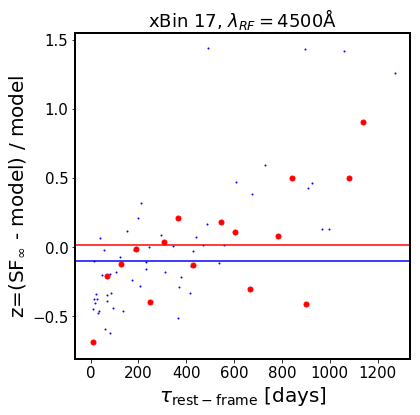

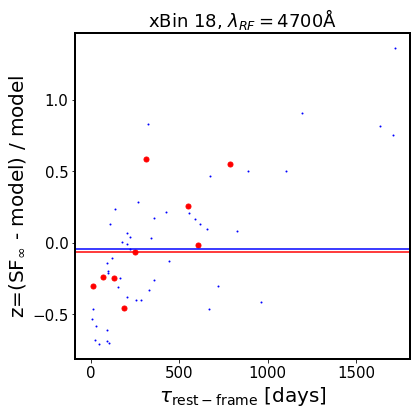

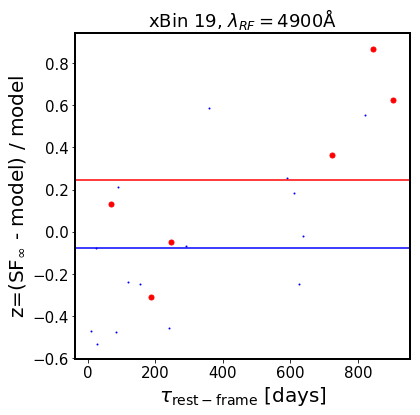

In [265]:
# 0 : xbins
# 1 : ybins
# 21 : len(np.unique(stats_sf.binnumber[0])) 

# select all input that ends up in 1st xbin
for binN in range(20):# 7
    binEdge = xedges[binN]
    binCenter = xcenters[binN]
    print('xBin', binN, ' left edge ',binEdge)
    print('xBin', binN,' center ', binCenter)
    xbinNumbers = stats_sf.binnumber[0]
    #ybinNumbers = 
    # for x-input it makes sense:
    #print(x[stats_sf.binnumber[0] == binN])
    # >> x[stats_sf.binnumber[0] == 1]
    # array([1173.20216918, 1172.23403004, 1132.02078389, 1147.04153212,
    #        1199.68517783, 1061.94994271, 1178.62257479, 1103.73325952,
    #        1179.53463493, 1165.2404313 ])
    # 
    # for y-input : 
    #print(y[stats_sf.binnumber[0] == binN])
    # y[stats_sf.binnumber[0] == 1]
    # array([351.13701923, 208.14159225,  12.8009104 , 458.46875777,
    #         96.52179389, 317.93974508, 411.48039233, 294.29845417,
    #        141.12419733,  85.25238026])

    fig,ax = plt.subplots(1,1,figsize=(6,6))
    # plot raw data in that column 
    ax.scatter(y[xbinNumbers == binN],z[xbinNumbers == binN], c='blue', s=1 )
    ax.axhline(np.median(z[xbinNumbers == binN]),c='blue')
    # plot the medians for that column 
    mask = XC == xcenters[binN]
    ax.scatter(Y[mask],H[mask],c='red', s=25)
    ax.axhline(np.median(H[mask][~np.isnan(H[mask])]),c='red')
    ax.set_xlabel(r'$\tau_{\mathrm{rest-frame}}$ [days]')
    ax.set_ylabel(cbar_label)
    ax.set_title('xBin '+str(binN)+r', $\lambda_{RF}=$'\
                 +str(int(binCenter))+r'$\mathrm{\AA}$')
    plt.savefig(figname[:-4]+'_xBin'+str(binN)+'.png', bbox_inches='tight')

In [260]:
figname[:-4]

'Ivezic_2004_Fig_1_sdss-ps1_v1div'

So the medians are calculated appropriately - now figure out why the raw-based statistic is so different than the median-based one .... 

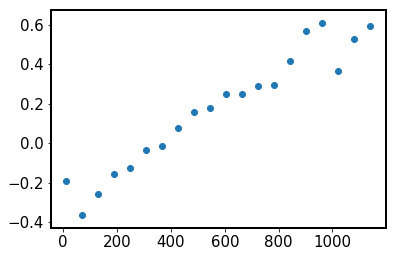

In [188]:

plt.scatter()

array([  10. ,   69.5,  129. ,  188.5,  248. ,  307.5,  367. ,  426.5,
        486. ,  545.5,  605. ,  664.5,  724. ,  783.5,  843. ,  902.5,
        962. , 1021.5, 1081. , 1140.5])

In [185]:
XC[XC   == 2500.]


array([2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500.,
       2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500., 2500.,
       2500., 2500.])

In [233]:
# median-based
hf = H.flatten()
xf = XC.flatten()
sel = ~np.isnan(hf)
stat_med, bin_edges,  binnumber = bs(xf[sel],hf[sel],
                                       statistic='median', bins=xedges)


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 330

In [237]:
bin_edges

array([1000., 1200., 1400., 1600., 1800., 2000., 2200., 2400., 2600.,
       2800., 3000., 3200., 3400., 3600., 3800., 4000., 4200., 4400.,
       4600., 4800., 5000.])

In [236]:
len(binnumber)

330

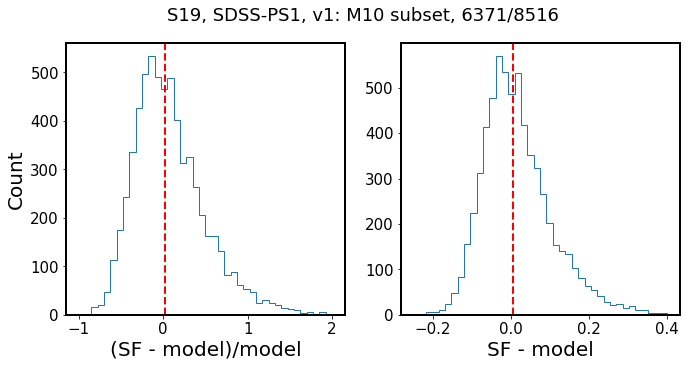

In [106]:
fig,ax = plt.subplots(1,2, figsize=(11,5))
ax[0].hist((SF-model)/model, histtype='step',range=(-1,2),bins=40)
ax[0].axvline(np.median((SF-model)/model),ls='--',lw=2,c='r')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('(SF - model)/model')

ax[1].hist(SF-model, histtype='step', range=(-.25,.4), bins=40)
ax[1].axvline(np.median(SF-model), ls='--',lw=2,c='r')
ax[1].set_xlabel('SF - model')

fig.suptitle(source + ', v'+ver+': '+title, fontsize=18)
plt.savefig('Fig26_SF_model_residuals_hist_v'+ver+'.png', bbox_inches='tight')

In [52]:
sf-model/mof

0.13602536612678448

In [53]:
np.median(qso_van['flux']/factor)

0.02035898227423396

In [58]:
shift

-0.06890211574913711

(array([3.100e+01, 3.368e+03, 1.431e+03, 5.100e+02, 4.100e+02, 3.550e+02,
        4.390e+02, 1.930e+02, 1.160e+02, 2.220e+02, 1.260e+02, 2.040e+02,
        1.100e+02, 6.800e+01, 4.100e+01, 3.100e+01, 1.400e+01, 1.300e+01,
        1.000e+01, 7.000e+00, 1.000e+01, 4.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 5.000e+00, 1.100e+01, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00]),
 array([-0.06890212, -0.05979423, -0.05068634, -0.04157845, -0.03247056,
        -0.02336268, -0.01425479, -0.0051469 ,  0.00396099,  0.01306888,
         0.02217677,  0.03128465,  0.04039254,  0.04950043,  0.05860832,
         0.06771621,  0.07682409,  0.08593198,  0.09503987,  0.10414776,
         0.11325565,  0.12236353,  0.13147142,  0.14057931,  0.1496872 ,
         0.15879509,  0.16790297,  0.17701086,  0.18611875,  0.19522664,
 

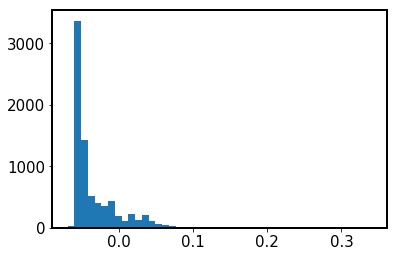

In [59]:
plt.hist(qso_van['flux']/factor+shift,bins=45)

The example below shows that I properly apply transpose ".T" to the results of binned_statistic_2d,  since it looks as it should from the following https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


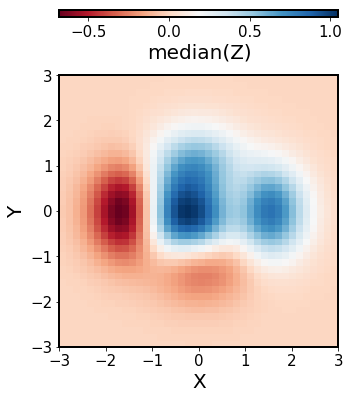

In [156]:
# code to make 2d heatmap with colorbar 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import binned_statistic_2d

fig,ax = plt.subplots(1,1,figsize=(5,5))

#x = np.random.normal(0,1,10000)
#y = np.random.normal(0,1,len(x))
X,Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
x = X.flatten()
y = Y.flatten()
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
#Z = np.sin(X+5*Y) # np.sqrt(Y)

gridsize=40 ; cmap = 'RdBu'
bottom, height =  1.04, 0.02

stats =  binned_statistic_2d(x,y,z, statistic='median', bins=gridsize)

H ,xedges, yedges= stats[0].T , stats[1], stats[2]

# span the grid 
X_,Y_ = np.meshgrid(xedges, yedges)
image = ax.pcolormesh(X_,Y_,H , cmap=cmap)

l,b,w,h = ax.get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label='median(Z)')

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.savefig('Fig_with_nice_colorbar.png', bbox_inches='tight', dpi=100)

array([-0.3198315 ,  2.50247823,  1.75523426, ...,  0.96302563,
       -0.89131505,  2.33972935])

In [ ]:
plt.hexbin

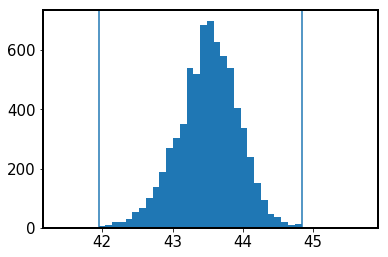

In [22]:
from scipy.stats import binned_statistic as bs 
# plot against anything MGII - related.... any trends ?  
# LOGL_MGII	 LOGL_MGII_ERR	FWHM_MGII	FWHM_MGII_ERR	EW_MGII	EW_MGII_ERR
col  
m1 = qso['EW_MGII'] > 0
xlim = [-1,1]
ylim = [42,45]
yplot = qso['LOGL_MGII']
m2 = (xlim[0]<f1)&(f1<xlim[1])&(ylim[0]<yplot) & (yplot<ylim[1])
m = m1 & m2 

fig, ax=  plt.subplots(1,1,figsize=(8,6))
ax.hexbin(f1[m],yplot[m], gridsize=25)

# calculate medians 
bin_edges = np.linspace(xlim[0],xlim[1],20)
stat_med, bin_edges1,  binnumber = bs(f1[m],yplot[m],statistic='median', bins=bin_edges)
bin_centers = (bin_edges1[1:] + bin_edges1[:-1] ) /2.
ax.scatter(bin_centers , stat_med, c = 'magenta', edgecolor='yellow',
          s=50)

ax.set_xlabel('residuals: '+r'$\log_{10}(\tau)-f(\lambda_{RF}, M_{i}, M_{BH})$')
ax.set_ylabel('LOGL_MGII')



array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ])

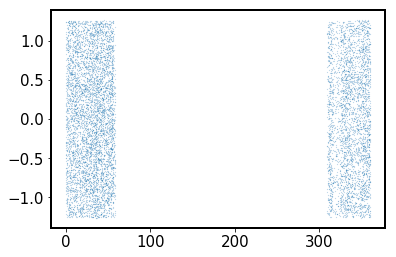

In [9]:
%matplotlib inline
plt.scatter(cat1.ra.deg,  cat1.dec.deg , s=0.01)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(array([9.660e+02, 4.569e+03, 2.046e+03, 7.950e+02, 3.850e+02, 1.900e+02,
        1.070e+02, 1.820e+02, 5.000e+00, 1.000e+00]),
 array([-0.22452117, -0.05158659,  0.12134799,  0.29428257,  0.46721715,
         0.64015174,  0.81308632,  0.9860209 ,  1.15895548,  1.33189006,
         1.50482465]),
 <a list of 1 Patch objects>)

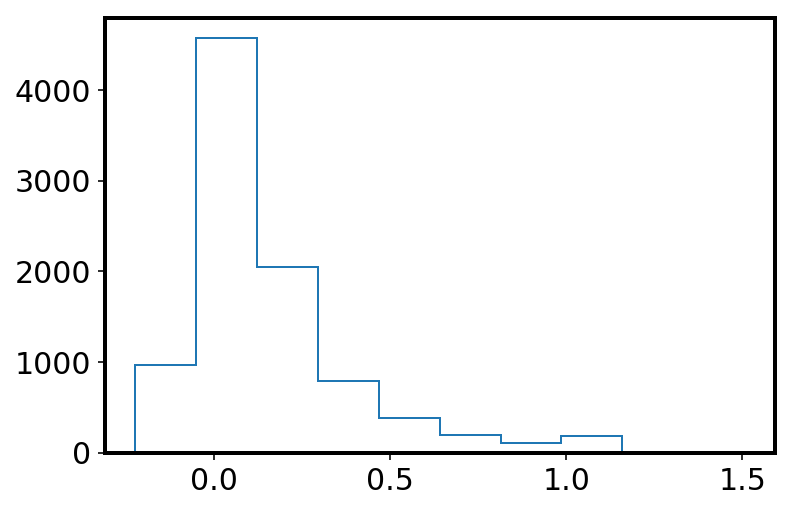

In [111]:
plt.hist(np.log10(qso['sigmaEXP_sdss-ps1']/qso['sigmaEXP_sdss']), histtype='step',
        )

## Fig.12 : Quasar properties <a id='qsoProperties'></a>

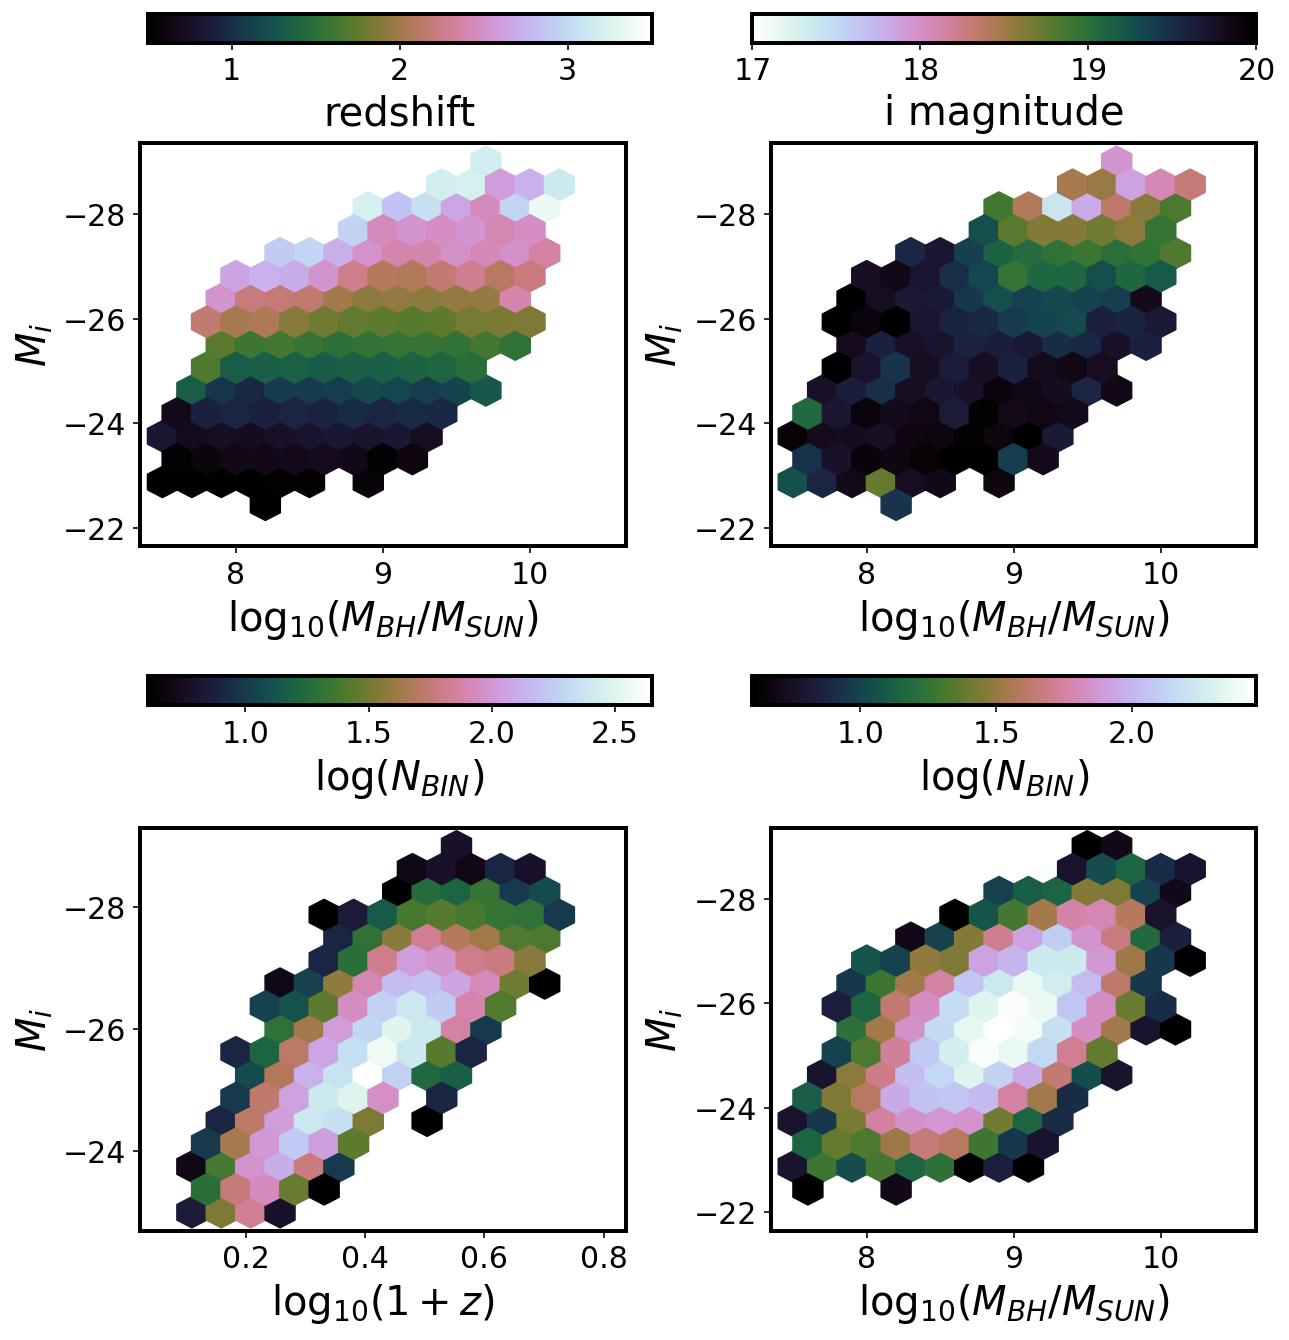

In [8]:
%config InlineBackend.figure_format='retina'

cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI = qso['MI_Z2'] # Shen2011 

## i-band magnitude  -use DBQSO now, but 
# later perhaps calculate the median of SDSS light curves ?  
# not sure what would be the difference - the light curves are not 
# corrected for extinction, but what about the DBQSO values ? 
imag = qso['i']

# redshift  : Shen2011 
z =  qso['REDSHIFT']

# black hole mass from Shen+2011
MBH = qso['LOGBH']

gridsize=15

fig,axs = plt.subplots(2,2, figsize=(10,10))
ax = np.ravel(axs)

# upper left 
image = ax[0].hexbin(MBH, MI, z , extent = [7.5,10.5, -22,-29], 
                     vmin = 0.5, vmax =3.5, mincnt=4, cmap=cmap, gridsize=gridsize)
ax[0].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[0].set_ylabel(r'$M_{i}$')
ax[0].invert_yaxis()

left, bottom, width, height = 0.13, 0.95, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label='redshift')

fig.subplots_adjust(hspace=0.4)


# upper right  
image = ax[1].hexbin(MBH, MI,imag ,
            extent = [7.5,10.5, -22,-29],vmin=17, vmax = 20, mincnt=4,
                     cmap=cmap+'_r', gridsize=gridsize)
ax[1].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[1].set_ylabel(r'$M_{i}$')
ax[1].invert_yaxis()

left, bottom, width, height = 0.55, 0.95, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
cbar = plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label='i magnitude')
#cbar.ax.invert_xaxis()


# lower left 
image = ax[2].hexbin(np.log10(1+z),MI,
            extent = [0.06,0.8, -23,-29],  cmap=cmap,
                    gridsize=gridsize, bins='log',mincnt=4)
#                     vmin = 0.6, vmax =3.5,) 
ax[2].set_xlabel(r'$\log_{10}{(1+z)}$')
ax[2].set_ylabel(r'$M_{i}$')
ax[2].invert_yaxis() 
left, bottom, width, height = 0.13, 0.49, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])

vmin, vmax = image.get_clim()
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cbar_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cbar_cmap.set_array([])

plt.colorbar(mappable = cbar_cmap, cax = cax, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')


# lower right 
image = ax[3].hexbin(MBH, MI,extent = [7.5,10.5, -22,-29],  cmap=cmap,
                    gridsize=gridsize, bins='log', mincnt=4
                    ) # vmin = 0.6, vmax =3., 
ax[3].invert_yaxis() 
ax[3].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[3].set_ylabel(r'$M_{i}$')
left, bottom, width, height = 0.55, 0.49, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])


vmin, vmax = image.get_clim()
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cmap.set_array([])

plt.colorbar(mappable = cmap, cax = cax, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')

fig.subplots_adjust(hspace=0.7,wspace=0.3)
plt.savefig('fig16.pdf', bbox_inches='tight', dpi=100)

On colormaps / colorbars 
https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
 https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629
 https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
 
 https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
 https://joseph-long.com/writing/colorbars/
 
 http://emptypipes.org/2014/09/05/python-scaled-colormap/
 http://www.sc.eso.org/~bdias/pycoffee/codes/20160602/colorbar_demo.html
 
 PyCoffee at ESO http://www.sc.eso.org/~bdias/pycoffee/ 

10.0 64.0


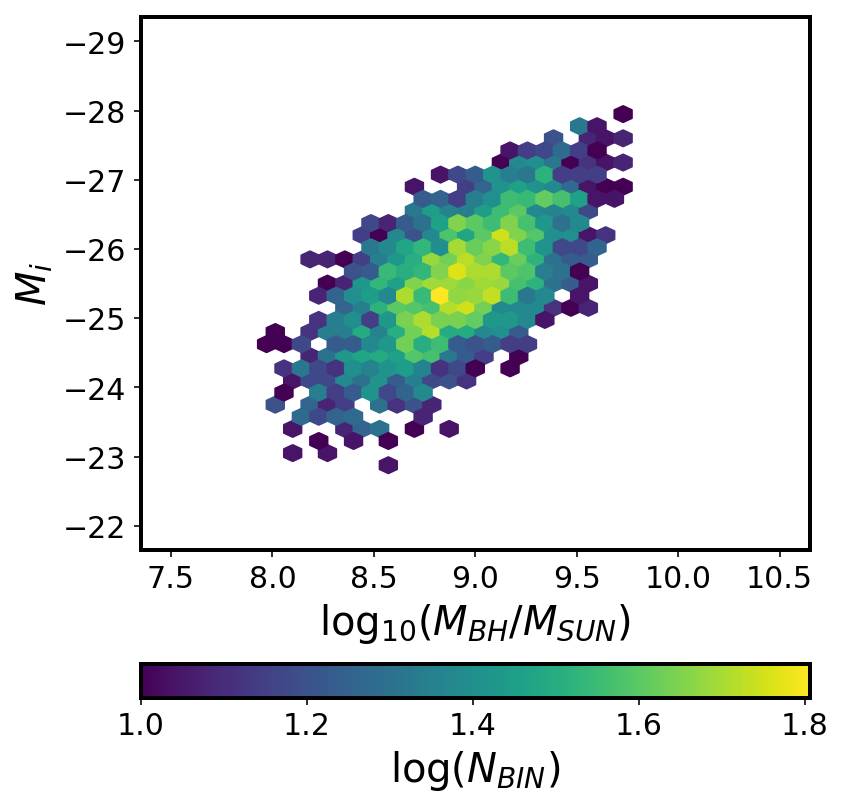

In [7]:
fig,ax =  plt.subplots(1,1,figsize=(6,7))
cmap = 'viridis'
image = ax.hexbin(MBH, MI,extent = [7.5,10.5, -22,-29],  cmap=cmap,
                    gridsize=35, bins='log', mincnt=10.
                    ) # vmin = 0.6, vmax =3., 
ax.invert_yaxis() 
ax.set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax.set_ylabel(r'$M_{i}$')
left, bottom, width, height = 0.55, 0.49, 0.35, 0.02

vmin, vmax = image.get_clim()
print(vmin,vmax)
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cmap.set_array([])

plt.colorbar(mappable = cmap, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')

## Fig.14 : trends with luminosity, black hole mass.... <a id='qsoTrends'></a>

In [10]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
date = '190807'# '190606' #  '190409'# '190606'
data = Table.read('../code2/'+date+'_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                  format='ascii')
s = Table.read('../code2/s82drw_r_lcname_flags.txt', format='ascii')
data = join(data,s[['lcname', 'flagM10select']],keys='lcname')

# select only those 6371 that fulfill Chelsea's criteria 
data = data[data['flagM10select'] == 1]

NameError: name 'figname' is not defined

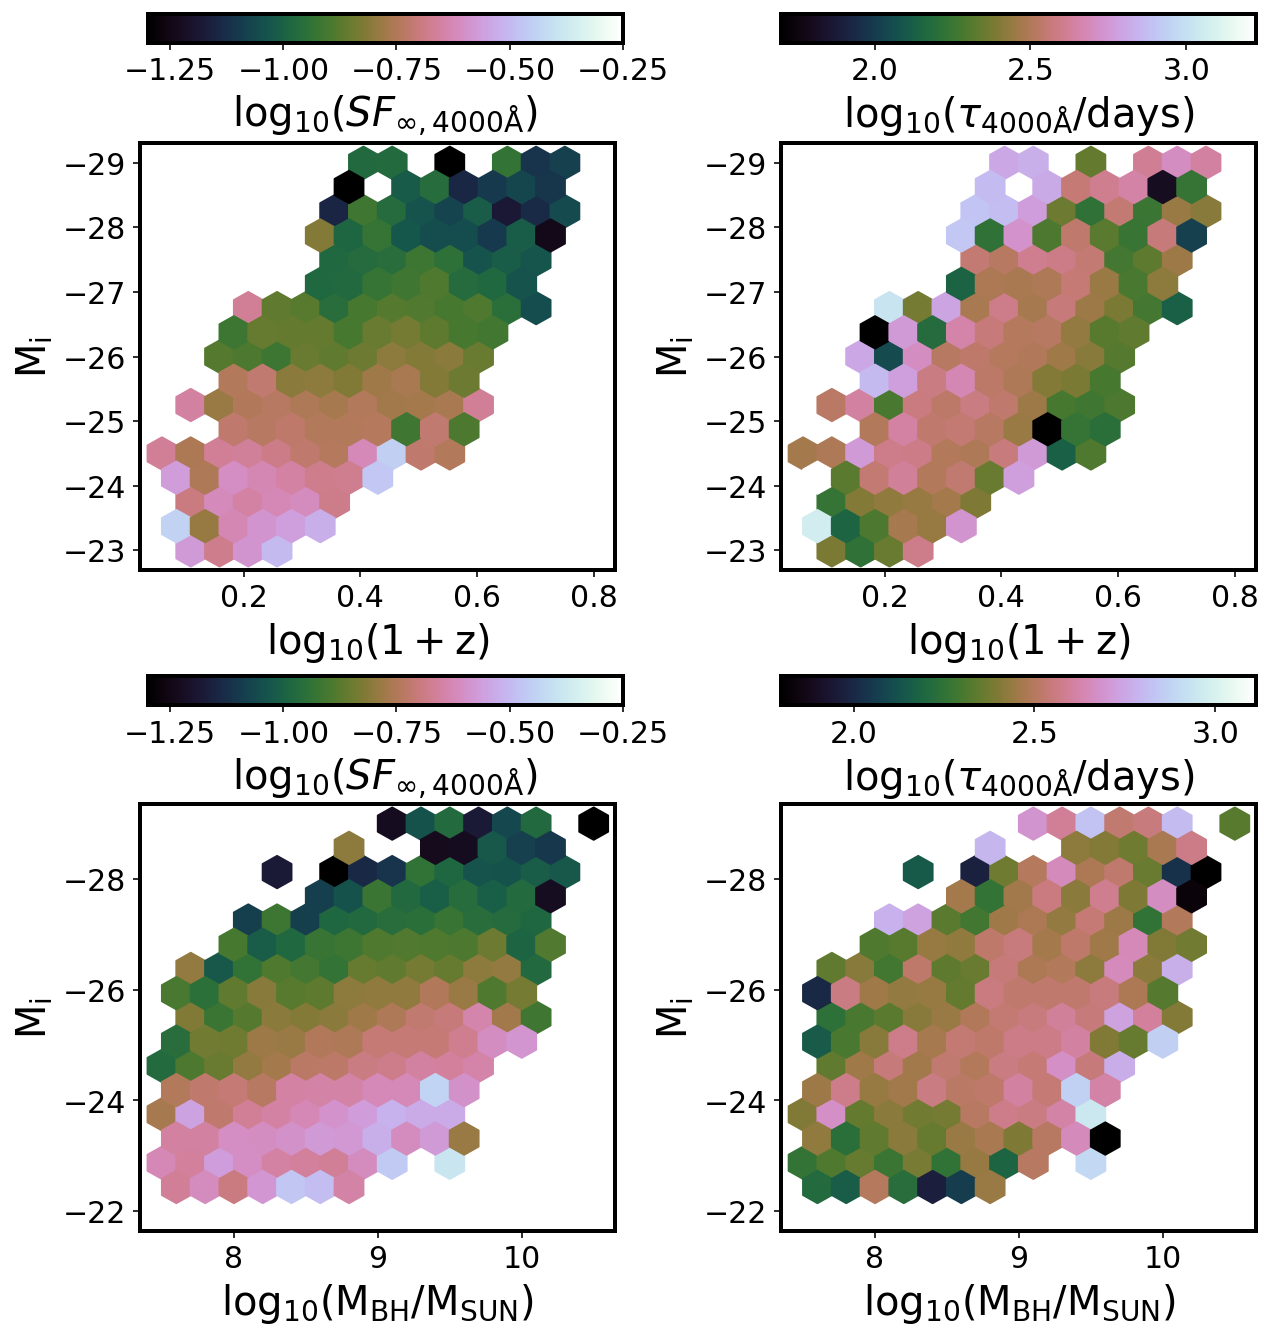

In [11]:
# Make figure like Fig.14 using Chelsea's results ...
fig,axs = plt.subplots(2,2, figsize=(10,10))
ax = np.ravel(axs)
cmap = 'cubehelix'#'magma'# 'viridis'

#lambdaobs = 6250 # angstroms  - since these are the results for 
# combined SDSS r-band, centered on 6250 Angstroms 
#qso['lambdaRF'] = lambdaobs /  (1.+ qso['REDSHIFT'])

seg = 'sdss-ps1'

tauRF = data['tauEXP_'+seg] / (1.+ data['REDSHIFT'])
tau4000 = tauRF * np.power(4000/data['lambdaRF'], 0.17) # B=0.17 for tau

sfinf = data['sigmaEXP_'+seg] * np.sqrt(2)
sf4000 = sfinf * np.power(4000/data['lambdaRF'], -0.479 ) # B = -0.479 for SFinf 


gridsize=15
m = data['tauEXP_'+seg] > 1

# plotted quantities : 
# absolute i-band magnitude 
Mi = data['MI_Z2'][m]

# black hole mass from Shen+2011 
MBH = data['LOGBH'][m]

# redshift
z = data['REDSHIFT'][m]

# tau corrected to 4000 A 
tau = tau4000[m]

# sf inf corrected to 4000 A 
sf = sf4000[m]

# upper left 
image = ax[0].hexbin(np.log10(1.+z), Mi, np.log10(sf),
            extent = [0.06,0.8, -23,-29], cmap=cmap, vmin=-1.3, vmax = -0.25,
            gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{\mathrm{(1+z)}}$')
left, bottom, width, height = 0.13, 0.95, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(SF_{\infty, 4000 \mathrm{\AA}})}$')




# lower left 
image = ax[2].hexbin(MBH,Mi, np.log10(sf),
            extent = [7.5,10.5, -22,-29],  cmap=cmap,
                    gridsize=gridsize, 
                     vmin = -1.3, vmax =-0.25, )
ax[2].invert_yaxis() 
ax[2].set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
left, bottom, width, height = 0.13, 0.49, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(SF_{\infty, 4000 \mathrm{\AA}})}$')


# upper right 
image = ax[1].hexbin(np.log10(1+z), Mi, np.log10(tau),
            extent = [0.06,0.8, -23,-29], cmap=cmap, gridsize=gridsize,
                    vmin=1.7)
#vmin=0.7, vmax = 3.0,
                           
ax[1].invert_yaxis()
ax[1].set_xlabel(r'$\log_{10}{\mathrm{(1+z)}}$')

left, bottom, width, height = 0.57, 0.95, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(\tau _{4000 \mathrm{\AA}}/\mathrm{days})}$')




# lower right 
image = ax[3].hexbin(MBH,Mi, np.log10(tau),
            extent = [7.5,10.5, -22,-29],  cmap=cmap, 
                    gridsize=gridsize, vmin=1.8 )# vmin =0.7, vmax=3.0,
                    #) # vmin = 0.6, vmax =3., 
ax[3].invert_yaxis() 
ax[3].set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
left, bottom, width, height = 0.57, 0.49, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(\tau_{4000 \mathrm{\AA}}/\mathrm{days})}$')


fig.subplots_adjust(hspace=0.4)

for i in range(len(ax)):
    ax[i].set_ylabel(r'$\mathrm{M_{i}}$')

fig.subplots_adjust(wspace=0.35 , hspace=0.55)
#fig.text(0.45,0.99,'Shen+2011', fontsize=19)
#figname =  'macleod2010_Fig14_Shen2011_'+seg+'_'+date+'_.png'
plt.savefig('fig17.pdf', bbox_inches='tight', dpi=100)
#print('Saved as ', figname)

(array([   4.,   10.,   27.,   61.,  113.,  248.,  739., 1963., 2653.,
         543.]),
 array([-0.25126596,  0.10195763,  0.45518121,  0.80840479,  1.16162837,
         1.51485196,  1.86807554,  2.22129912,  2.5745227 ,  2.92774629,
         3.28096987]),
 <a list of 10 Patch objects>)

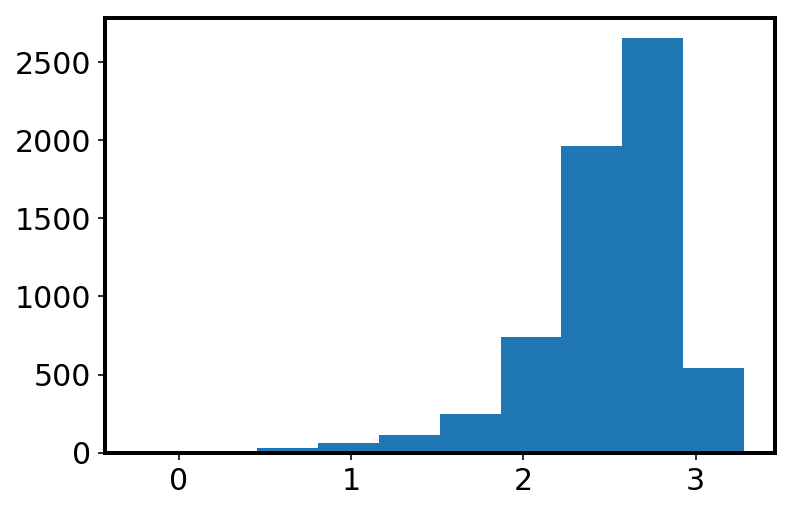

In [10]:
plt.hist(np.log10(tau))

# Consider the Eddington ratio : Fig.15 ... 

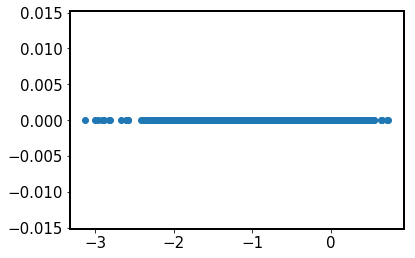

In [21]:
%matplotlib inline
m = qso['LOGEDD_RATIO'] > -4
x = qso['LOGEDD_RATIO'][m]
y = qso['LOGLBOL'][m] - np.log10(1.26) - 38 - qso['LOGBH'][m]
plt.scatter(x, x-y)

Ok , so obviously Shen+2011 assumes that   $L_{Edd} = 1.26 \cdot 10^{38} M_{BH} / M_{\circ}$  rather than  MacLeod+2010  $L_{Edd} = \textbf{1.5}\cdot 10^{38} M_{BH} / M_{\circ}$  


In [37]:
s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')

In [39]:
qso = s82r

In [6]:
qso = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', format='ascii')

In [3]:
#qso

<Table masked=True length=9246>
   lcname      length_sdss     ...     LOGEDD_RATIO            MI_Z2       
   str11         float64       ...       float64              float64      
----------- ------------------ ... -------------------- -------------------
     70.txt 3336.9332799999975 ... -0.09588690464482141  -24.28560773968867
     98.txt  2582.962741999996 ...  -1.4968484216898403  -23.96421289067481
    233.txt 3321.0338420000044 ...  -1.0698767980049055 -25.008960685706665
   1018.txt 3336.9333019999976 ...  -1.7286712247357983  -24.03915568655799
   1310.txt  3321.033924000003 ...  -0.5604819556203395 -26.916981368954627
   1327.txt  3336.933323999998 ...  -0.8443757941170773  -25.23082414221863
   1540.txt  3321.033884999997 ... -0.41253305911254046  -27.80633729514747
   1580.txt 3336.9332989999966 ...  -0.8456619732497614 -24.738376414675884
   2113.txt        3321.033829 ...  -1.2200747094901558 -25.535346152682955
   2306.txt 3321.0339909999966 ... -0.36707121298938006 -25.275683639463445
        ...                ... ...                  ...                 ...
7904816.txt 3321.0338880000054 ...  -0.5242171665281887  -25.15770111233168
7906590.txt 3321.0338619999966 ...  -1.3511186067403713 -24.739420443117048
7906964.txt 3336.9333100000003 ...  -0.5924879720670333 -27.380627531622935
7907016.txt 2934.9387080000015 ...    -0.85362142565819  -26.00361724782843
7907462.txt  3336.956116000001 ...  -1.4581690767517728 -24.710373341540745
7908238.txt  2934.938764999999 ...  -0.8328332732849546 -25.842518206640886
7910366.txt 3336.9561900000044 ...   -0.703689706247566 -25.183615192032455
7911306.txt 3336.9562589999987 ... -0.43581254165726335 -27.490134582365325
7911499.txt  2934.938691999996 ...  -1.2434284605390076  -24.91520090209982
7913279.txt 3336.9333049999987 ...  -1.4404508825242885  -25.12553695182227

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saved as  Eddington_ratio_Shen2011_Chelsea_SDSS_ugriz.png


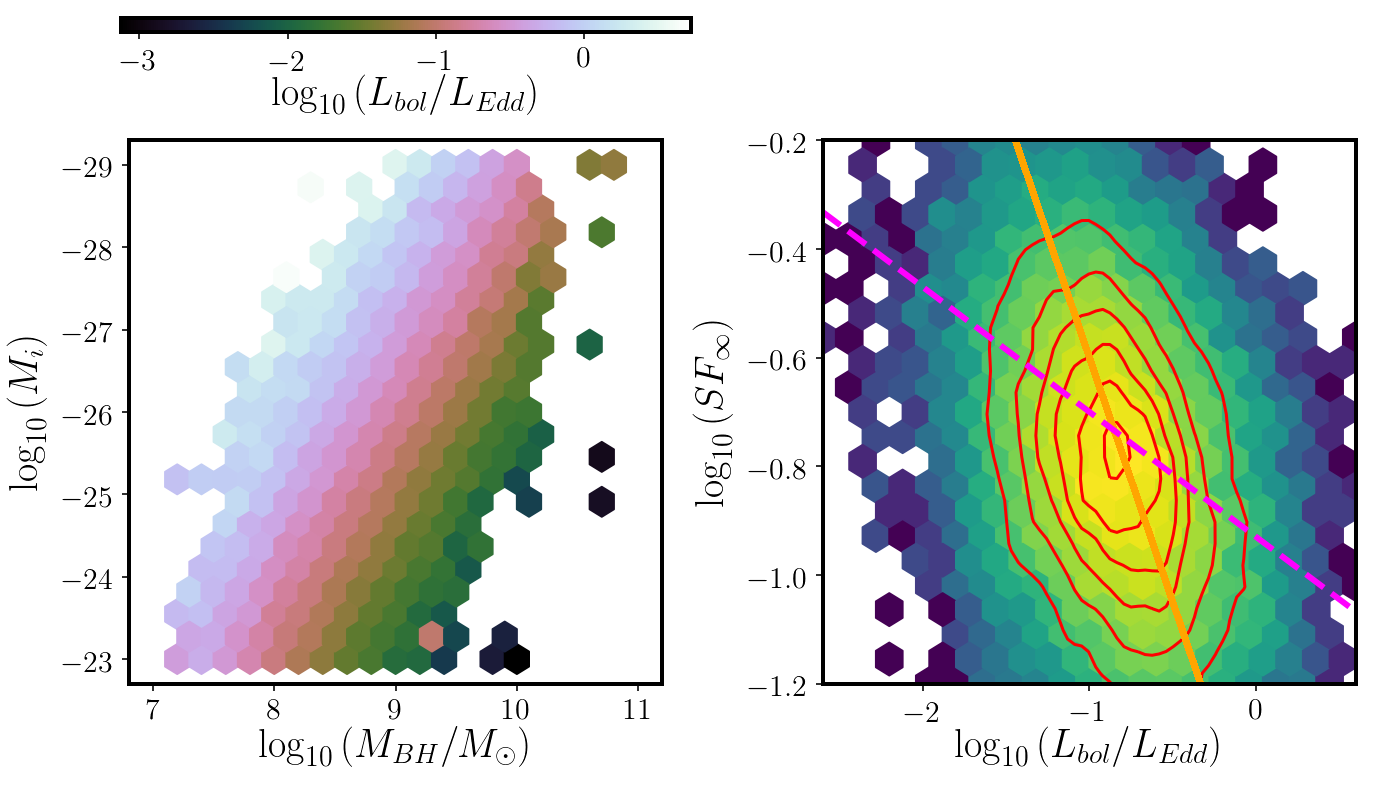

In [558]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns

cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI = qso['MI_Z2'] # Shen2011 
#MI = qso['M_i_corr']
# redshift  : Shen2011 
z =  qso['REDSHIFT']
#z = qso['redshift']
# black hole mass from Shen+2011
MBH = qso['LOGBH']
#MBH = qso['mass_BH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = qso['LOGEDD_RATIO'] # Shen2011
#logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
# Chlsea's definition of LEdd (1.5 rather than 1.26 )
#logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008


lambdaobs = 6250 # angstroms  - since these are the results for 
# combined SDSS r-band, centered on 6250 Angstroms 
lambdaRF = lambdaobs /  (1.+z)

seg = 'sdss-ps1' # sdss'# 'sdss-ps1'

#tauRF = qso['tauEXP_'+seg] / (1.+z)  # shift to rest frame 
#tau4000 = tauRF * np.power(4000/lambdaRF, 0.17) # B=0.17 for tau

#sfinf = qso['sigmaEXP_'+seg] * np.sqrt(2) # no need to shift anything 
sfinf = qso['SFinf']
#sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
sf4000 = qso['SFinf4000']

fig,axs = plt.subplots(1,2, figsize=(11,5))
ax = np.ravel(axs)

gridsize=20
m = logEddRatio  >  -4 
#m = (qso['tauEXP_'+seg] > 5 )&(logEddRatio > -4)


if seg == 'sdss-ps1':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.2,-0.2]
    
if seg == 'sdss':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.2,-0.2]
    
# left panel 
image = ax[0].hexbin(MBH[m], MI[m], logEddRatio[m],
            extent = extent0, cmap=cmap, gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[0].set_ylabel(r'$\log_{10}{(M_{i})}$')


left, bottom, width, height = 0.12, 1.03, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')

# right panel

#ax[1].scatter(logEddRatio, np.log10(sf4000), s=0.05, c='blue')
x,y = logEddRatio[m].data, np.log10(sf4000[m].data)


ax[1].set_xlim(extent1[0],extent1[1])
ax[1].set_ylim(extent1[2],extent1[3])
ax[1].hexbin(x,y,bins='log',mincnt=1, gridsize=gridsize,
            extent = extent1)


# contours with single color
sns.kdeplot(x,y, n_levels=6, ax=ax[1],
                linestyles='-', linewidth=2, cmap=None, colors='red', )
# shaded contours
#sns.kdeplot(x,y, n_levels=6, ax=ax[1],
#                linestyles='-', linewidth=2, cmap='Blues_r', )


# plot the medians too ..
xlim = ax[1].get_xlim()
min_x, max_x , step_size = xlim[0],xlim[1], 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
#ax[1].scatter(mean_x[:-1], median_y[:-1], c = 'magenta', )


# stats on log ... 
#stats = binned_statistic(x,y,statistic = 'median', bins=40)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(bins,  stats.statistic,  c = 'magenta', edgecolors='orange')

#bins =  np.linspace(np.power(10,xmin), np.power(10,xmax), 40)
#stats = binned_statistic(np.power(10,x), np.power(10,y), statistic='median', bins=bins)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(np.log10(bins),  np.log10(stats.statistic),
#              c = 'magenta', edgecolors='orange')





# overplot a straight line fit ..
#from scipy.optimize import curve_fit
def func(x, a, b):
    return a*x + b

#popt, pcov = curve_fit(func, x, y)
#ax[1].plot(x, func(x, *popt), 'r-',)
#...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))



ax[1].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[1].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')

ax[1].plot(x, func(x,-0.9, -1.5 ), ls = '--', lw=3, c='orange',label='-0.9')

# plot Chelsea's slope...
x_ = np.linspace(-2.6,0.6)
ax[1].plot(x_, -0.23*x_ - 0.93, lw=3, ls='--', c='magenta', label='-0.23')

#ax[1].legend(loc='upper left', bbox_to_anchor=(1,1),
#            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 

fig.subplots_adjust(wspace=0.3)
#plt.savefig('macleod2010_Fig15_shen2011_SDSS-PS1.png', bbox_inches='tight')
#fname =  'Eddington_ratio_Shen2011_'+seg+'.png'
fname =  'Eddington_ratio_Shen2011_Chelsea_SDSS_ugriz.png'
print('Saved as ', fname)
plt.savefig(fname,   bbox_inches='tight', dpi=100)

In [66]:
# only Chelsea results 
# cross-matched to Shen2008 and shen2011
qso = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', 
                 format='ascii')

32936

In [12]:
# Chelsea r-band and Celerite
qso = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                 format='ascii')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


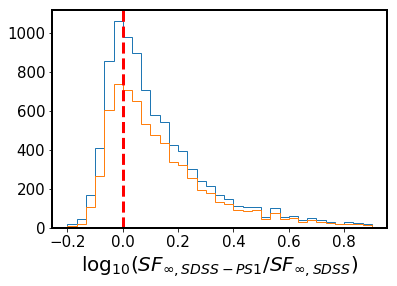

In [16]:
%matplotlib inline

# impose Chelsea's constraints ... 
m2 = qso['Plike'] - qso['Pnoise'] > 2 
m3 = qso['Plike'] - qso['Pinf'] > 0.05 
m4 = qso['edge'] == 0 
m = m2&m3&m4 


# Compare the two SFinf ...
sfinf1 = qso['sigmaEXP_sdss-ps1'] * np.sqrt(2) # no need to shift anything 
#sf4000_1 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 

sfinf2 = qso['sigmaEXP_sdss'] * np.sqrt(2) # no need to shift anything 
#sf4000_2 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 


plt.hist(np.log10(sfinf1 / sfinf2), bins=33, range=(-0.2, 0.9), histtype='step')
plt.hist(np.log10(sfinf1[m] / sfinf2[m]), bins=33, range=(-0.2, 0.9), histtype='step')

plt.axvline(0, ls='--', lw=3,c='r')
#plt.xlim(-0.3, 0.9)
plt.xlabel(r'$\log_{10}{(SF_{\infty, SDSS-PS1} / SF_{\infty,  SDSS} )}$')
plt.savefig('Compare_SFinf_4000AA_Celerite.png', bbox_inches='tight', dpi=100)

In [8]:
qso

<Table length=33218>
SDR5ID     ra        dec    ...        MI_Z2        d2d_asec_DBQSO M_i_corr
int64   float64    float64  ...       float64          float64     float64 
------ ---------- --------- ... ------------------- -------------- --------
   301   2.169302  1.238649 ...  -24.28560773968867            0.0  -24.181
   144   1.091028  0.962126 ...  -23.96421289067481            0.0  -23.576
    58   0.331289   0.17723 ... -25.008960685706665            0.0  -25.058
   190   1.364696 -0.098956 ...  -24.03915568655799            0.0  -24.045
    36   0.221552 -0.292485 ... -26.916981368954627            0.0  -26.974
    49    0.28137  0.686984 ...  -25.23082414221863            0.0  -25.288
   370   2.607954  0.913245 ...  -27.80633729514747            0.0  -27.856
   229   1.669492  0.643952 ... -24.738376414675884            0.0  -24.898
   699   4.850273 -0.276395 ... -25.535346152682955            0.0  -25.695
    83   0.537709  0.098021 ... -25.106504077770243            0.0   -25.56
   ...        ...       ... ...                 ...            ...      ...
    -1  24.622953  1.015446 ... -25.860063546225792            0.0     -1.0
    -1  36.243603  1.109054 ... -23.214604572945564            0.0     -1.0
    -1  36.676086  1.049125 ...  -24.89172441245773            0.0     -1.0
    -1  45.519508  1.134007 ... -23.758050234431135            0.0     -1.0
    -1  46.085861  1.074533 ... -23.991204571305325            0.0     -1.0
    -1  46.557655  1.093343 ... -24.445645229211152            0.0     -1.0
    -1  52.467354  1.035224 ... -23.666448817232048            0.0     -1.0
    -1  23.716694  1.255406 ... -23.706025270243813            0.0     -1.0
    -1  44.045433  1.223469 ... -23.546216749725822            0.0     -1.0
    -1 352.900955  1.201872 ... -24.927829214937514            0.0     -1.0

In [ ]:
s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')

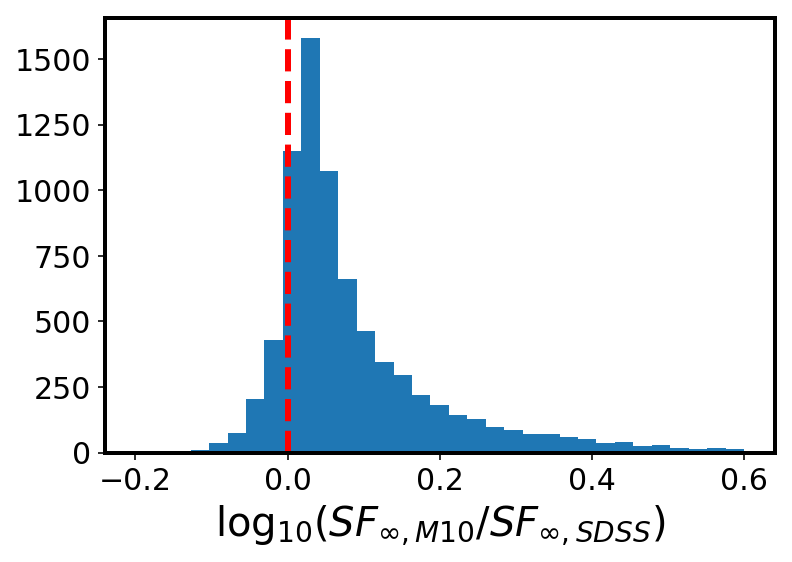

In [47]:
# Compare the two SFinf ...
sfinf1 = qso['SFinf'] #qso['sigmaEXP_sdss-ps1'] * np.sqrt(2) # no need to shift anything 
sf4000_1 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 

sfinf2 = qso['sigmaEXP_sdss'] * np.sqrt(2) # no need to shift anything 
sf4000_2 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 


plt.hist(np.log10(sfinf1 / sfinf2), bins=33, range=(-0.2, 0.6))
plt.axvline(0, ls='--', lw=3,c='r')
#plt.xlim(-0.3, 0.9)
plt.xlabel(r'$\log_{10}{(SF_{\infty, M10} / SF_{\infty,  SDSS} )}$')
plt.savefig('Compare_SFinf_4000AA_Celerite_Chelsea.png', bbox_inches='tight', dpi=100)

In [68]:
stats.statistic

array([-0.80674312, -0.67726086, -1.02824732,         nan, -0.39630279,
               nan, -0.48048727, -0.63348159, -0.68665524, -0.75842155,
       -0.48850667, -0.50216794, -0.5731691 , -0.57590331, -0.59614473,
       -0.62426178, -0.61356717, -0.64878623, -0.66856974, -0.67955962,
       -0.68339228, -0.71942388, -0.72517475, -0.74397096, -0.76662836,
       -0.78049892, -0.7885407 , -0.80843638, -0.83368093, -0.82899181,
       -0.84566301, -0.83088883, -0.90046967, -0.94746409, -0.84874961,
       -0.96970596, -0.8764347 , -0.85215692, -0.88857812, -1.16757747])

Check the K-correction factors from http://www.astrouw.edu.pl/~simkoz/AGNcalc/ : are they to z=2 or z=0 ? Plot k as a function of redshift

In [5]:
k = Table.read("Kcorr_QSO_r.dat.txt", format='ascii',names=['z',"K"])

Text(0, 0.5, 'K corr')

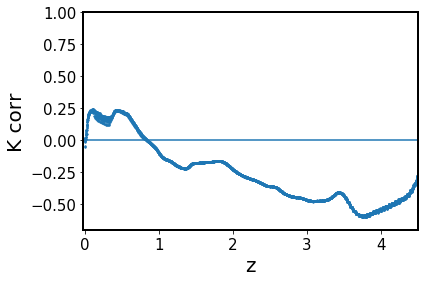

In [23]:
%matplotlib inline
plt.scatter(k['z'], k['K'],s=2 )
plt.ylim(-0.7,1)
plt.xlim(-0.02,4.5)
plt.axhline(0)
plt.xlabel('z')
plt.ylabel("K corr")

it is 0 at z=0 as well as z~0.75 .... Thus I think he's correcting to z=0.

In [6]:
x

array([[-2.77770063, -2.21179288],
       [-2.96869531,  0.20040625],
       [-1.95008602, -3.33216565],
       ...,
       [ 2.28435697,  2.66877899],
       [-0.5436443 ,  0.4007885 ],
       [ 1.68840284,  1.19997144]])

Do the test : 
* generate a y = f(x) distribution where slope is known , eg. 2D Gaussian  https://www.astroml.org/book_figures/chapter3/fig_bivariate_gaussian.html 
* fit with AstroML total least squares for slope
* add errors
* fit again, see how errors affect the recovered slope ... 

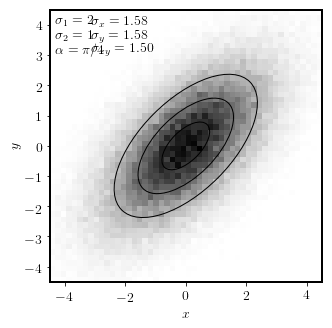

In [62]:
from matplotlib.patches import Ellipse
from astroML.stats.random import bivariate_normal
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

#------------------------------------------------------------
# Define the mean, principal axes, and rotation of the ellipse
mean = np.array([0, 0])
sigma_1 = 2
sigma_2 = 1
alpha = np.pi / 4

#------------------------------------------------------------
# Draw 10^5 points from a multivariate normal distribution
#
#   we use the bivariate_normal function from astroML.  A more
#   general function for this is numpy.random.multivariate_normal(),
#   which requires the user to specify the full covariance matrix.
#   bivariate_normal() generates this covariance matrix for the
#   given inputs.
np.random.seed(0)
x, cov = bivariate_normal(mean, sigma_1, sigma_2, alpha, size=100000,
                          return_cov=True)

sigma_x = np.sqrt(cov[0, 0])
sigma_y = np.sqrt(cov[1, 1])
sigma_xy = cov[0, 1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# plot a 2D histogram/hess diagram of the points
H, bins = np.histogramdd(x, bins=2 * [np.linspace(-4.5, 4.5, 51)])
ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
          extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])

# draw 1, 2, 3-sigma ellipses over the distribution
for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean, N * sigma_1, N * sigma_2,
                         angle=alpha * 180. / np.pi, lw=1,
                         ec='k', fc='none'))

kwargs = dict(ha='left', va='top', transform=ax.transAxes)

ax.text(0.02, 0.98, r"$\sigma_1 = %i$" % sigma_1, **kwargs)
ax.text(0.02, 0.93, r"$\sigma_2 = %i$" % sigma_2, **kwargs)
ax.text(0.02, 0.88, r"$\alpha = \pi / %i$" % (np.pi / alpha), **kwargs)

ax.text(0.15, 0.98, r"$\sigma_x = %.2f$" % sigma_x, **kwargs)
ax.text(0.15, 0.93, r"$\sigma_y = %.2f$" % sigma_y, **kwargs)
ax.text(0.15, 0.88, r"$\sigma_{xy} = %.2f$" % sigma_xy, **kwargs)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

In [14]:
np.zeros_like(x)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [63]:
# we can assume that the points above have no errors at all...
# then the recovered slope should align with the principal ellipse axis, i.e.
# slope should be 0.5 

from scipy import optimize
from astroML.linear_model import TLS_logL
from astroML.stats import fit_bivariate_normal
# Fit x1 and y1 :  
# stack the latent variables x1,y1  ....
#X = np.vstack((x1, y1)).T
#dX = np.zeros((len(x1), 2, 2))
# x as constructed above is already a (N,2) array \
# which is exactly what we get by 
# operating with X = np.vstack((x1,y1)).T
# if the two arrays have length N,
# shape of X is (N,2)

x1,y1 = np.vsplit(x.T,2) #  undoes the operation 
X = np.vstack((x1, y1)).T
dX = np.zeros((len(x1), 2, 2))
#dX = np.zeros_like(x)  # : no errors whatsoever. ...
dX[:, 0, 0] = 0.00001 #sigma_lum ** 2
dX[:, 1, 1] = 0.00001 #sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 
    
    
min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,x0=[1,1])
print(beta_fit)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b

slope, offset  = get_m_b(beta_fit)
print('offset ', offset, 'slope ', slope)

AssertionError: 

[0.59875969 0.00741086]


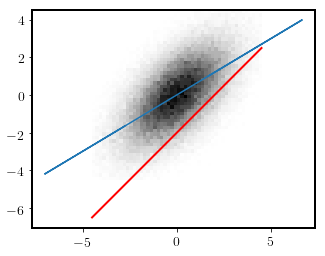

In [54]:
%matplotlib inline
fig,ax  = plt.subplots()
ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
          extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])
x_fit = np.linspace(bins[0][0], bins[0][-1])
ax.plot(x_fit, -slope * x_fit - offset, '-r',lw=2)

x1,y1 = np.vsplit(x.T,2)
z = np.polyfit(x1[0],y1[0],1)
print(z)
p = np.poly1d(z)

#plt.scatter(x1,y1,s=0.0001)
ax.plot(x1[0], p(x1[0]))

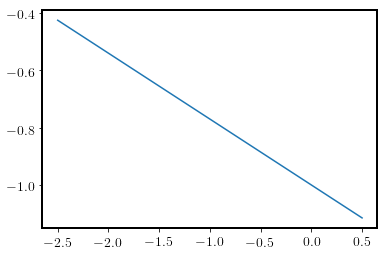

In [67]:
x = np.linspace(-2.5,0.5,1000)
y = -0.23 * x - 1
plt.plot(x,y)

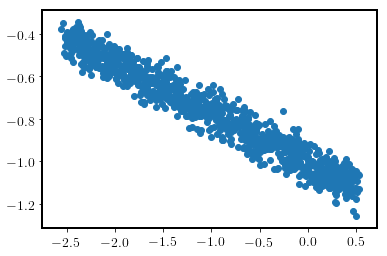

In [76]:
x = np.linspace(-2.5,0.5,1000)
y = -0.23 * x - 1
plt.plot(x,y)
xobs = x + np.random.normal(0,0.05, len(x))
yobs = y + np.random.normal(0,0.05, len(x))
plt.scatter(xobs,yobs)

Rotation angle is  -0.2260683879938839  rad
i.e.  -12.952764513375518  deg
True slope :  -0.23
Fitting observed distr, assuming considerable obs error 
sigma_x= 0.2  sigma_y= 0.01
Optimization terminated successfully.
         Current function value: 429684.483065
         Iterations: 63
         Function evaluations: 120
Recovered slope with AstroML (incl.errors):  -1.8021219917558666
Fitting bivariate normal recovered slope is  -0.23045138311602886
Fitting bivariate normal recovered alpha is  -0.226497050341176


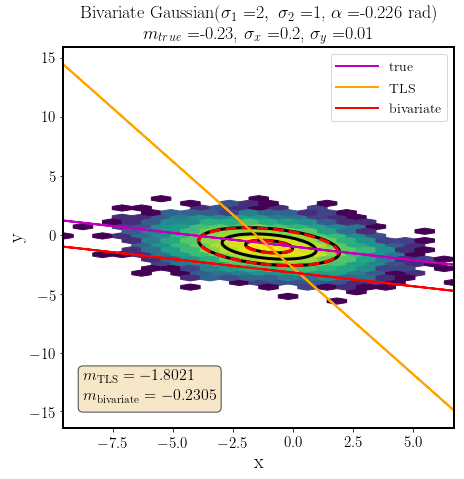

In [553]:
from astroML.stats import fit_bivariate_normal
mean = [-1,-1]
stdev_1 = 2 # distribution spread in x direction before rotation 
stdev_2 = 1 # distribution spread in y direction before rotation
slope = -0.23 # 0.5#-0.23 # the slope in the desired target distribution 
#slope=0.5
#  a basis for calculating the rotation angle 
rotation =  np.arctan(slope)  #  rotation angle in radians 
print('Rotation angle is ', rotation ,' rad')
print('i.e. ',np.rad2deg(rotation), ' deg')
# generate bivariate Gaussian 
x, cov = bivariate_normal(mean, stdev_1, stdev_2, rotation, size=10000,
                          return_cov=True)

#stdev_x =np.sqrt(cov[0, 0])
#stdev_y = np.sqrt(cov[1, 1])
#cov_xy = cov[0, 1]

print('True slope : ', slope)
# plot it 
x1,y1 = np.vsplit(x.T,2)
x1 = x1[0]
y1 = y1[0]

# add to observed x,y  values an offset drawn from a Gaussian distribution....
# otherwise we're fitting an intrinsic, but not the observed, distribitopn...

fit_parent = False
if fit_parent : 
    print('Fitting parent distr, assuming tiny observational error ')
    sigma_x = 1e-6
    sigma_y = 1e-6  # basically no error 
    print('sigma_x = sigma_x = ', sigma_x)
    
if not fit_parent : #  fitting the observed distribution : 
    # adding the observational error 
    # Chelsea assumed error on SFinf as 0.01 # yvar in the sf model in idl file...
    print('Fitting observed distr, assuming considerable obs error ')
    sigma_x = 0.2  # error on log(L/Ledd), 
                   # corresponding to error on log(MBH), which is 0.2
    sigma_y = 0.01 # error on SFinf , Chelsea assumes 0.01 in the IDL code 
    print('sigma_x=',sigma_x, ' sigma_y=', sigma_y )
    
# to the underlying dist. add observed error
xobs = x1  + np.random.normal(0,sigma_x, len(x1))
yobs = y1  + np.random.normal(0,sigma_y, len(y1))
   

fig,ax = plt.subplots(1,1, figsize=(7,7))
# plt.scatter(x1,y1)
#ax.errorbar(x1,y1,sigma_x,sigma_y, fmt='none', ecolor='b', capthick=2)


import seaborn as sns

# plot the observed distribution ... 
cmap = 'viridis' ; gridsize=20 
ax.hexbin(xobs,yobs,bins='log',mincnt=1, gridsize=gridsize,)
#            extent = extent1)

# plot the parent distribution slope
ax.plot(xobs,slope*xobs+mean[0],lw=2, c='m', label='true')

# draw 1, 2, 3-sigma ellipses over the true distribution
for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean, N * stdev_1, N * stdev_2,
                         angle=rotation * 180. / np.pi, lw=3,
                         ec='k', fc='none'))
    
# contours with single color
#sns.kdeplot(x1,y1, n_levels=6, ax=ax,
#                linestyles='-', linewidth=2, cmap=None, colors='red', )


# fit with polyfit ...
#z = np.polyfit(x1,y1,1)
#poly = np.poly1d(z)
#plt.plot(x1,poly(x1), lw=2, c='r', ls='--')
#print('Recovered slope with polyfit (no errors):  ', z[0])
#

# fit with AstroML
# http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html
X_ = np.vstack((xobs,yobs)).T
dX =  np.zeros((len(xobs), 2, 2))
dX[:,0,0] = sigma_x ** 2.0 
dX[:,1,1] = sigma_y ** 2.0 
dX[:,0,1] = dX[:,1,0] = 0 # cov_xy

min_func = lambda beta: -TLS_logL(beta, X_, dX)
beta_fit = optimize.fmin(min_func,x0=[1,-1])
#print(beta_fit)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b
slope_tls, offset  = get_m_b(beta_fit)
print('Recovered slope with AstroML (incl.errors): ', slope_tls)
ax.plot(xobs, slope_tls*xobs+offset, ls='-',lw=2,c='orange', label='TLS')


# fit with astroML code, robust fit 
(mu_r, sigma1_r, sigma2_r, alpha_r) = fit_bivariate_normal(xobs, yobs, robust=True)
slope_r = np.tan(alpha_r) # alpha is rotation in radians 
for Nsig in [1, 3]:
    E = Ellipse(mu_r, sigma1_r * Nsig, sigma2_r * Nsig, (alpha_r * 180. / np.pi),
                    ec='r', fc='none', linestyle='dashed',lw=3)
    ax.add_patch(E)
print('Fitting bivariate normal recovered slope is ', slope_r )
print('Fitting bivariate normal recovered alpha is ', alpha_r)
ax.plot(xobs, slope_r*xobs+offset-0.4, ls='-',lw=2,c='red',
       label='bivariate')


ax.legend()
ax.set_title('Bivariate Gaussian('+r'$\sigma_{1}=$'+str(stdev_1)+\
            r'$,\,\,\sigma_{2}=$'+str(stdev_2)+r', $\alpha=$'+\
             str(rotation.round(3))+' rad) '+'\n'+r'$m_{true} = $'+\
             str(slope)+', '+r'$\sigma_{x}=$'+str(sigma_x)+\
             r',  $\sigma_{y}=$'+str(sigma_y))
ax.set_xlabel('x')
ax.set_ylabel('y')

# ax.text(0.1,0.2,r'$m_{TLS} = $'+str(slope_tls.round(3)),
#         transform=ax.transAxes)
# ax.text(0.1,0.1,r'$m_{biv} = $'+str(slope_r.round(3)),
#         transform=ax.transAxes)
textstr = '\n'.join((
    r'$m_{\mathrm{TLS}}=%.4f$' % (slope_tls, ),
    r'$m_{\mathrm{bivariate}}=%.4f$' % (slope_r, )
                    ))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

# place a text box in upper left in axes coords
ax.text(0.05, 0.15, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

plt.savefig('Bivariate_dist_fit_TLS_biv.png', bbox_inches='tight', dpi=100)

* with AstroML Total Least Squares, if I assume true errors , I get grossly wrong slope - but perhaps it is incorrect to tell astromL that there is no covariance whereas in reality all points are related in some way ... (?)
- if I feed it with the real covariance it gets it wrong, but that's because it's asking for error covariance , not covariance of the entire distribution...
* if I assume tiny errors for AstroML,  I get the right answer ...
* if I use the fit_bivariate_normal() from astroML, I get the right answer of course....(plotting the recovered means, stdevs, rotation with dashed ellipses)

Iterate over a range of x errors and see how the answer changes.. Fix y error at 0.001 :

In [240]:

def fit_tls_bivariate(x, sigma_x, sigma_y, verbose=False):
    x1,y1 = np.vsplit(x.T,2)
    x1 = x1[0]
    y1 = y1[0]
    if verbose:
        print('sigma_x=',sigma_x, ' sigma_y=', sigma_y )
    
    # to the underlying dist. add observed error
    x1 = x1  + np.random.normal(0,sigma_x, len(x1))
    y1 = y1  + np.random.normal(0,sigma_y, len(y1))
    
    # fit with AstroML
    # http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html
    X = np.vstack((x1,y1)).T
    dX =  np.zeros((len(x1), 2, 2))
    dX[:,0,0] = sigma_x ** 2.0 
    dX[:,1,1] = sigma_y ** 2.0 
    dX[:,0,1] = dX[:,1,0] = 0 # cov_xy : we assume errors are uncorrelated 

    min_func = lambda beta: -TLS_logL(beta, X, dX)
    beta_fit = optimize.fmin(min_func,x0=[1,-1], disp=0)
    #print(beta_fit)
    def get_m_b(beta):
        b = np.dot(beta, beta) / beta[1]
        m = -beta[0] / beta[1]
        return m, b
    slope_tls, offset  = get_m_b(beta_fit)
    if verbose:
        print('Recovered slope with AstroML (incl.errors): ', slope_tls)
        
    # fit with astroML code, robust fit 
    (mu_r, sigma1_r, sigma2_r, alpha_r) = fit_bivariate_normal(x1, y1, robust=True)
    slope_bivariate = np.tan(alpha_r) # alpha is rotation in radians 
    if  verbose : 
        print('Fitting bivariate normal recovered slope is ', slope_bivariate )
    return slope_tls, slope_bivariate

In [250]:
sigma_x_grid = np.logspace(-4,-1,100)
sigma_y_grid = np.logspace(-4,-1,100)

N = len(sigma_x_grid) * len(sigma_y_grid )
sig_x_col = np.zeros(N)
sig_y_col =  np.zeros(N)
sl_tls_col=  np.zeros(N)
sl_biv_col = np.zeros(N)
i = 0 
for sigma_x in sigma_x_grid:
    if i % 100 == 0 :
        print(i)
    for sigma_y in sigma_y_grid:
        slope_tls, slope_bivariate = fit_tls_bivariate(x, sigma_x,sigma_y, 
                                                       verbose=False)
        sig_x_col[i] = sigma_x
        sig_y_col[i] = sigma_y
        sl_tls_col[i] =  slope_tls
        sl_biv_col[i] = slope_bivariate
        i += 1 

        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [251]:
t = Table(data = [sig_x_col, sig_y_col, sl_tls_col, sl_biv_col],
     names=['sigma_x', 'sigma_y', 'slope_tls', 'slope_biv'])
t.write('Fit_slope_bivariate_Gaussian.txt', format='ascii')

(array([2551.,  608.,  247.,  237.,  173.,  177.,  181.,  279., 2065.,
        3470.]),
 array([-1.8 , -1.62, -1.44, -1.26, -1.08, -0.9 , -0.72, -0.54, -0.36,
        -0.18,  0.  ]),
 <a list of 10 Patch objects>)

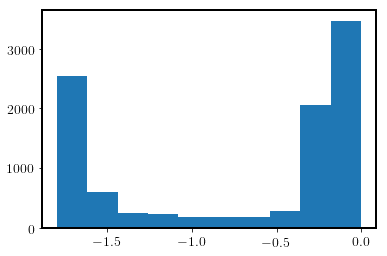

In [418]:
plt.hist(t['slope_tls'], range=(-1.8,0))

In [326]:
plt.hexbin?

(0, 8)

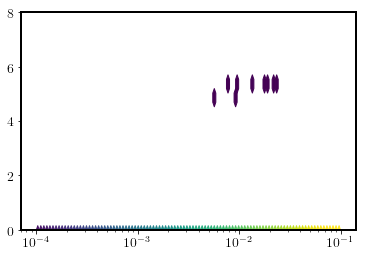

In [337]:
plt.hexbin(t['sigma_y'],t['slope_tls'], mincnt=1, xscale='log',)#extent=(-4,-1,5,5))
plt.ylim(0,8)

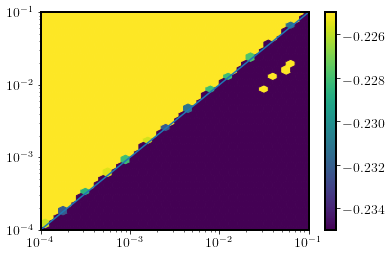

In [437]:
slope_truth = -0.23 

plt.hexbin(t['sigma_x'], t['sigma_y'] ,t['slope_tls'],
          xscale='log', yscale='log', vmin=-0.235, vmax=-0.225
           ,gridsize=30,)
plt.plot(t['sigma_x'],t['sigma_x'])
plt.colorbar()# vmin=0, vmax=8,

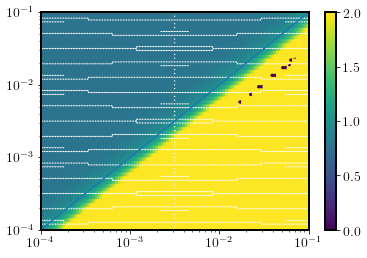

In [442]:
slope_truth = -0.23 

plt.hexbin(t['sigma_x'], t['sigma_y'] ,t['slope_tls']/slope_truth,vmin=0,vmax=2,
          xscale='log', yscale='log', )
plt.plot(t['sigma_x'],t['sigma_x'])
plt.colorbar()# vmin=0, vmax=8,

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


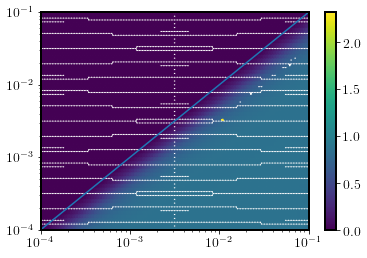

In [462]:
z = np.log10(t['slope_tls'].data/slope_truth)
plt.hexbin(t['sigma_x'], t['sigma_y'] ,z,vmin=0,
          xscale='log', yscale='log', mincnt=0)
plt.plot(t['sigma_x'],t['sigma_x'])
plt.colorbar()

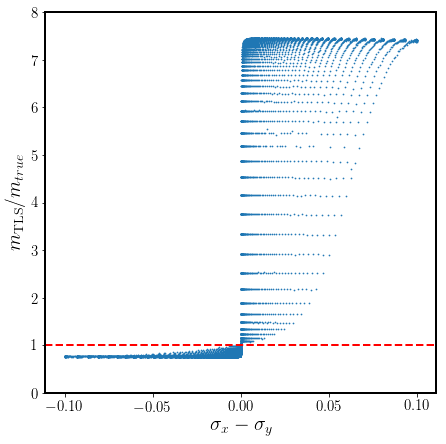

In [554]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(t['sigma_x'] - t['sigma_y'] , t['slope_tls']/slope_truth, s=0.5)
ax.set_ylim(0,8)
ax.axhline(1,ls='--', lw='2', c='r')
ax.set_ylabel(r'$m_{\mathrm{TLS}} / m_{true}$')
ax.set_xlabel(r'$\sigma_{x} - \sigma_{y}$')
plt.savefig('bivariate_fit_sig_x_sig_y_TLS.png', bbox_inches='tight', dpi=100)

The transition for TLS occurs precisely where the x-errors start being bigger than the y-errors...

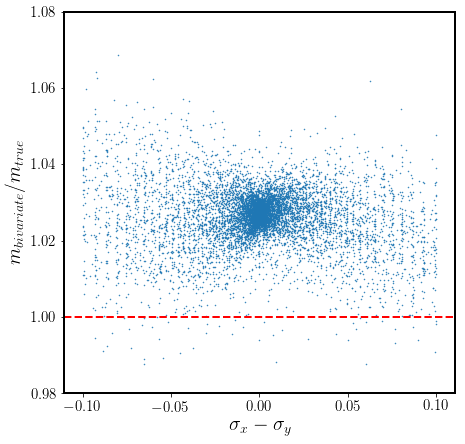

In [555]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(t['sigma_x'] - t['sigma_y'] , t['slope_biv']/slope_truth, s=0.25)
ax.set_ylim(0.98,1.08)
ax.axhline(1,ls='--', lw='2', c='r')
ax.set_ylabel(r'$m_{bivariate} / m_{true}$')
ax.set_xlabel(r'$\sigma_{x} - \sigma_{y}$')
plt.savefig('bivariate_fit_sig_x_sig_y_biv.png', bbox_inches='tight', dpi=100)

Meanwhile,  for bivariate distribution, it's insensitive to errors, because it doesn't take them into consideration...

(-1, 0)

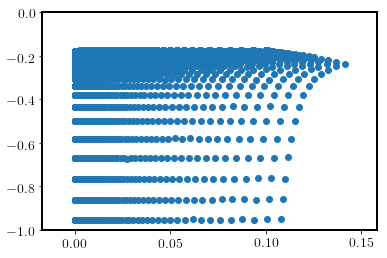

In [398]:
plt.scatter(np.sqrt(t['sigma_x']**2 + t['sigma_y']**2), t['slope_tls'])
plt.ylim(-1,0)

(array([3826., 1709.,  279.,  181.,  177.,  174.,  238.,  324.,  755.,
        2325.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

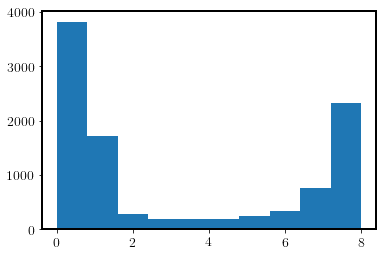

In [307]:
slope_truth = -0.23 
plt.hist(t['slope_tls'] / slope_truth, range=(0,8.))#, range=(-3,2))

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3904., 1046.,  394.,  284.,   94.,  183.,  179.,  175.,  325.,
         921.]),
 array([-0.2  , -0.095,  0.01 ,  0.115,  0.22 ,  0.325,  0.43 ,  0.535,
         0.64 ,  0.745,  0.85 ]),
 <a list of 10 Patch objects>)

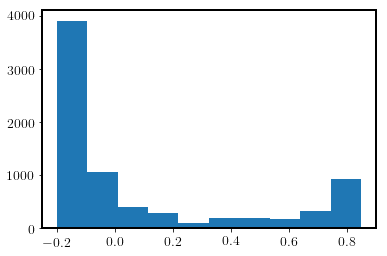

In [355]:
slope_truth = -0.23 
plt.hist(np.log10(t['slope_tls'] / slope_truth), range=(-0.2,.85))#, range=(-3,2))

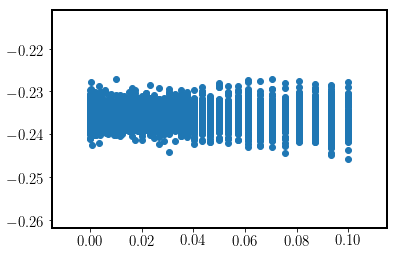

In [482]:
plt.scatter(t['sigma_y'], t['slope_biv'])

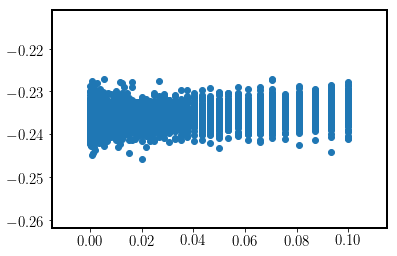

In [483]:
plt.scatter(t['sigma_x'], t['slope_biv'])

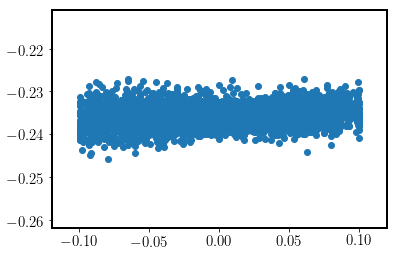

In [484]:
plt.scatter(t['sigma_x']-t['sigma_y'], t['slope_biv'])

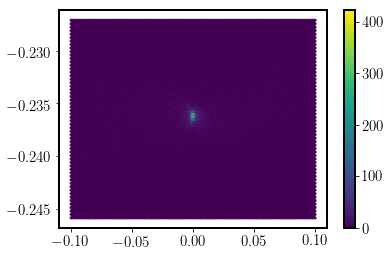

In [481]:
plt.hexbin(t['sigma_x']-t['sigma_y'], 
           t['slope_biv'])
plt.colorbar()

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


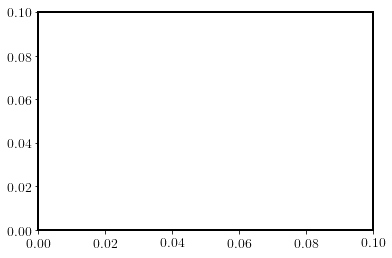

In [263]:
from scipy.stats import binned_statistic_2d
stats = binned_statistic_2d(sig_x_col,sig_y_col,sl_tls_col, 
                           statistic = 'median',)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = plt.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))

In [236]:
image

In [264]:
x = sig_x_col
y = sig_y_col
z_list = sl_tls_col
H, bins = np.histogramdd(x, bins=2 * [np.linspace(-4.5, 4.5, 51)])
ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
          extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])



ValueError: The dimension of bins must be equal to the dimension of the  sample x.

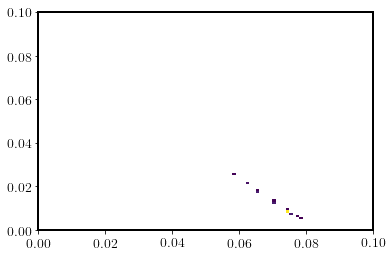

In [265]:
x_list = sig_x_col
y_list = sig_y_col
z_list = sl_tls_col

N = int(len(z_list)**.5)
z = z_list.reshape(N, N)
from matplotlib.colors import LogNorm
plt.imshow(z, extent=(np.amin(x_list), np.amax(x_list), 
                      np.amin(y_list), np.amax(y_list)), 
           norm=LogNorm(), aspect = 'auto')



In [87]:
# an y=x line  with slope =1  has a 45 degree angle ...
# np.arctan(1) gives the angle corresponding to that slope in radians, and 
# np.rad2deg converts the radians to degrees 
# np.rad2deg(np.arctan(1))

# so line with slope -0.23 has a degree 


0.2260683879938839

### Use AstroML TLS as well as bivariate distr. to fit Fig.17 distributions of $SF_{\infty,4000}$ vs $L/L_{Edd}$  , using Chelsea data ... 

In [21]:

def fit_tls_bivariate(x1,y1,sigma_x, sigma_y, verbose=True):
    
    X = np.vstack((x1,y1)).T
    dX =  np.zeros((len(x1), 2, 2))
    
    #if type(sigma_x) is float : 
    dX[:,0,0] = sigma_x ** 2.0 
    #else:  # assume sigma_x is an arry 
    #    assert len(sigma_s) == len(x1)
    #dX[:,0,0] = sigma_x ** 2.0 
        
    #if len(sigma_y) == 1 : 
    dX[:,1,1] = sigma_y ** 2.0 
    dX[:,0,1] = dX[:,1,0] = 0 # cov_xy : we assume errors are uncorrelated 

    min_func = lambda beta: -TLS_logL(beta, X, dX)
    beta_fit = optimize.fmin(min_func,x0=[1,-1], disp=0)
    #print(beta_fit)
    def get_m_b(beta):
        b = np.dot(beta, beta) / beta[1]
        m = -beta[0] / beta[1]
        return m, b
    slope_tls, offset_tls  = get_m_b(beta_fit)
    if verbose:
        print('Recovered slope with AstroML (incl.errors): ', slope_tls)
        
    # fit with astroML code, robust fit 
    (mu_r, sigma1_r, sigma2_r, alpha_r) = fit_bivariate_normal(x1, y1, robust=True)
    slope_bivariate = np.tan(alpha_r) # alpha is rotation in radians 
    if  verbose : 
        print('Fitting robust bivariate dist. the slope is ', slope_bivariate )
        
    return slope_tls, offset_tls, slope_bivariate



In [24]:
# select which data to plot
data_source = 'chelsea'# celerite'#'celerite' 

# choose what to fit : medians or the data ? 
fit_medians = True

# Chelsea results 
if data_source is 'chelsea':
    qso_ = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', 
                      format='ascii')
    qso = qso_#[:1000]
    
# Celerite results 
if data_source is 'celerite':
    s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                      format='ascii')
    qso = s82r#[:1000]

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/c

Fitting the medians 
Recovered slope with AstroML (incl.errors):  -0.20554469627022004
Fitting robust bivariate dist. the slope is  -0.18549092887595955
Saved as  Eddington_ratio_Shen2011_Chelsea_SDSS_ugriz_median_y_e.png


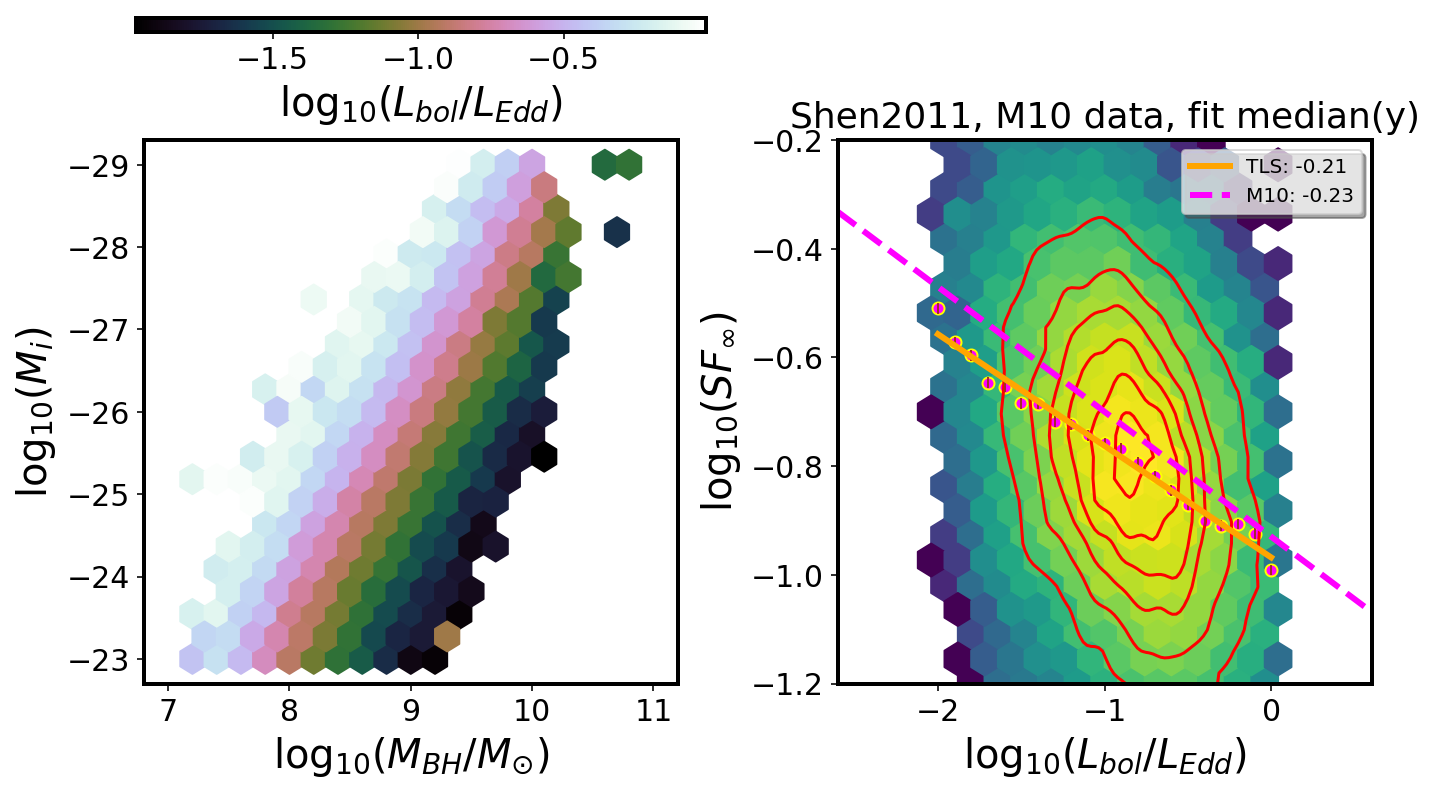

In [28]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns

from scipy import optimize
from astroML.linear_model import TLS_logL
from astroML.stats import fit_bivariate_normal
cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI = qso['MI_Z2'] # Shen2011 
#MI = qso['M_i_corr']
# redshift  : Shen2011 
z =  qso['REDSHIFT']
#z = qso['redshift']
# black hole mass from Shen+2011
MBH = qso['LOGBH']
#MBH = qso['mass_BH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = qso['LOGEDD_RATIO'] # Shen2011
#logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
# Chlsea's definition of LEdd (1.5 rather than 1.26 )
#logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008

if data_source is 'celerite':
    lambdaobs = 6250 # angstroms  - since these are the results for 
    # combined SDSS r-band, centered on 6250 Angstroms 
    lambdaRF = lambdaobs /  (1.+z)

    seg = 'sdss-ps1' # sdss'# 'sdss-ps1'

    #tauRF = qso['tauEXP_'+seg] / (1.+z)  # shift to rest frame  
    # tau4000 = tauRF * np.power(4000/lambdaRF, 0.17) # B=0.17 for tau

    sfinf = qso['sigmaEXP_'+seg] * np.sqrt(2) # no need to shift anything 
    sfinf = qso['SFinf']
    sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
    where =  'Celerite_'+seg+'_r'
    what_data = 'celerite'
    
if data_source is 'chelsea':
    sf4000 = qso['SFinf4000']
    where  = 'Chelsea_SDSS_ugriz'
    what_data = 'M10'

fig,axs = plt.subplots(1,2, figsize=(11,5))
ax = np.ravel(axs)

gridsize=20
#m1 =  ( -4 < logEddRatio) & (  logEddRatio  <  1  ) #  logEddRatio  >  -4 
m1 =  ( -2 < logEddRatio) & (  logEddRatio  <  0)
m2 = np.log10(sf4000.data) > -6 
m = m1 * m2 
#m = (qso['tauEXP_'+seg] > 5 )&(logEddRatio > -4)


# if seg == 'sdss-ps1':
#     extent0 = [7,11, -23,-29]
#     extent1 = [-2.6,0.6, -1.2,-0.2]
    
# if seg == 'sdss':
#     extent0 = [7,11, -23,-29]
#     extent1 = [-2.6,0.6, -1.2,-0.2]
    
# left panel 
extent0 = [7,11, -23,-29]
image = ax[0].hexbin(MBH[m], MI[m], logEddRatio[m],
            extent = extent0, cmap=cmap, gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[0].set_ylabel(r'$\log_{10}{(M_{i})}$')


left, bottom, width, height = 0.12, 1.03, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')

# right panel
extent1 = [-2.6,0.6, -1.2,-0.2]
#ax[1].scatter(logEddRatio, np.log10(sf4000), s=0.05, c='blue')
x,y = logEddRatio[m].data, np.log10(sf4000[m].data)


ax[1].set_xlim(extent1[0],extent1[1])
ax[1].set_ylim(extent1[2],extent1[3])
ax[1].hexbin(x,y,bins='log',mincnt=1, gridsize=gridsize,
            extent = extent1)


# contours with single color
sns.kdeplot(x,y, n_levels=6, ax=ax[1],
                linestyles='-', linewidth=2, cmap=None, colors='red', )
# shaded contours
#sns.kdeplot(x,y, n_levels=6, ax=ax[1],
#                linestyles='-', linewidth=2, cmap='Blues_r', )


# plot the medians too ..
xlim = ax[1].get_xlim()
min_x, max_x , step_size = xlim[0],xlim[1], 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
median_y_err = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
    median_y_err[j] = np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
    # formula 3.38 , yellow book 
    
ax[1].scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow')
ax[1].errorbar(mean_x, median_y, yerr = 0.01, xerr = 1e-6, 
            ecolor='brown', elinewidth=1, fmt='none')

# stats on log ... 
#stats = binned_statistic(x,y,statistic = 'median', bins=40)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(bins,  stats.statistic,  c = 'magenta', edgecolors='orange')

#bins =  np.linspace(np.power(10,xmin), np.power(10,xmax), 40)
#stats = binned_statistic(np.power(10,x), np.power(10,y), statistic='median', bins=bins)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(np.log10(bins),  np.log10(stats.statistic),
#              c = 'magenta', edgecolors='orange')

lw = 3

if fit_medians: # fit the medians 
    print('Fitting the medians ')
    mask_bad = ~np.isnan(median_y)
    x1=mean_x[mask_bad] ;  y1 = median_y[mask_bad]
    #sigma_x = 1e-10 ; sigma_y=median_y_err[mask_bad]
    sigma_x = 1e-10; sigma_y = 0.01
    
    ax[1].set_title('Shen2011, '+what_data+' data, fit median(y)')
    fname =  'Eddington_ratio_Shen2011_'+where+'_median_y_e.png'
    
if not fit_medians: # fit the distributon 
    print('Fitting the observed distribution ')
    x1=x ; y1 = y
    sigma_x = 0.2; sigma_y=0.01 
    ax[1].set_title('Shen2011, '+what_data +' data, fit x,y')
    fname =  'Eddington_ratio_Shen2011_'+where+'_x_y_e.png'
    
slope_tls, offset_tls, slope_bivariate = fit_tls_bivariate(x1,y1,
                                           sigma_x, sigma_y)
# plot the fitted slopes 
x_ = np.linspace(min(x),max(x),100)
ax[1].plot(x_, x_*slope_tls+offset_tls, c='orange',lw=lw,
          label='TLS: '+str(slope_tls.round(2)))
if not fit_medians: 
    ax[1].plot(x_, x_*slope_bivariate -0.93, c='red',lw=lw,
              label='Bivariate: '+str(slope_bivariate.round(2)))


ax[1].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[1].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')

#ax[1].plot(x, func(x,-0.9, -1.5 ), ls = '--', lw=3, c='orange',label='-0.9')

# plot Chelsea's slope...
x_ = np.linspace(-2.6,0.6)
ax[1].plot(x_, -0.23*x_ - 0.93, lw=lw, ls='--', c='magenta', label='M10: -0.23')

#ax[1].legend(loc='upper left', bbox_to_anchor=(1,1),
#            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 
ax[1].legend(fancybox=True, shadow=True,framealpha=0.7 )

fig.subplots_adjust(wspace=0.3)
#plt.savefig('macleod2010_Fig15_shen2011_SDSS-PS1.png', bbox_inches='tight')
#fname =  'Eddington_ratio_Shen2011_'+seg+'.png'

print('Saved as ', fname)
plt.savefig(fname,   bbox_inches='tight', dpi=100)

Using SDSS-PS1 , fitting xy with Bivariate, I get -0.493.   Fitting the medians with TLS I get -0.138.  The mean is  -0.3155 , i.e. still a steeper slope... Although Chelsea's slope looks perfectly well on top of the median distribution! 

Use Chelsea`s method....( 2D hist, binning with binned_statistic_2d, calc medians, errors , etc, to check that I do get the same... )n

In [3]:
# select which data to plot
data_source = 'chelsea'# celerite'#'celerite' 

# choose what to fit : medians or the data ? 
fit_medians = True

# Chelsea results 
if data_source is 'chelsea':
    qso_ = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', 
                      format='ascii')
    qso = qso_#[:1000]
    
# Celerite results 
if data_source is 'celerite':
    s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', 
                      format='ascii')
    qso = s82r#[:1000]

In [ ]:

from scipy.stats import binned_statistic_2d
fig,ax = plt.subplots(figsize=(8,6))

x = np.random.random(1000)
y = np.power(np.sin(x), 2.5) + 0.5 * np.random.random(1000)

stats = binned_statistic_2d(x, y, values = x, statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap='jet')  # np.log10(z_masked) gives log counts 

# add a colorbar  : define cax : colorbar axis 
colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])     #  (x0 ,y0  , dx,  dy )  
colorbar = fig.colorbar(image, cax = colorbar_ax,  orientation='vertical’)

# reduce number of ticks of a colorbar … (to eg 5 bins,  i.e.  4  tick labels )
from matplotlib import ticker
#tick_locator = ticker.MaxNLocator(nbins=5)
#colorbar.locator = tick_locator
#colorbar.update_ticks()
#class matplotlib.colorbar.ColorbarBase(ax, cmap=None, 
#    norm=None, alpha=None, values=None, boundaries=None, 
#    orientation='vertical', ticklocation='auto', 
#    extend='neither', spacing='uniform', ticks=None, format=None, 
#    drawedges=False, filled=True, extendfrac=None, extendrect=False, label='')

# another way is to say which axis it should be attached to … 
#colorbar = fig.colorbar(image, ax = ax[0],  orientation='vertical’)

# labels, ticks of  colorbar can be changed… 
colorbar.set_label(r'$count$', fontsize=20)
#ticks = colorbar.ax.get_xticks()
#colorbar.set_ticks(ticks[::2])
#colorbar.set_ticks([0.5,1,1.5])
#colorbar.set_ticklabels(['0.5','1', '1.5’])

In [4]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns

from scipy import optimize
from astroML.linear_model import TLS_logL
from astroML.stats import fit_bivariate_normal
cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI = qso['MI_Z2'] # Shen2011 
#MI = qso['M_i_corr']
# redshift  : Shen2011 
z =  qso['REDSHIFT']
#z = qso['redshift']
# black hole mass from Shen+2011
MBH = qso['LOGBH']
#MBH = qso['mass_BH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = qso['LOGEDD_RATIO'] # Shen2011
#logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
# Chlsea's definition of LEdd (1.5 rather than 1.26 )
#logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008

if data_source is 'celerite':
    lambdaobs = 6250 # angstroms  - since these are the results for 
    # combined SDSS r-band, centered on 6250 Angstroms 
    lambdaRF = lambdaobs /  (1.+z)

    seg = 'sdss-ps1' # sdss'# 'sdss-ps1'

    #tauRF = qso['tauEXP_'+seg] / (1.+z)  # shift to rest frame  
    # tau4000 = tauRF * np.power(4000/lambdaRF, 0.17) # B=0.17 for tau

    sfinf = qso['sigmaEXP_'+seg] * np.sqrt(2) # no need to shift anything 
    sfinf = qso['SFinf']
    sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
    where =  'Celerite_'+seg+'_r'
    what_data = 'celerite'
    
if data_source is 'chelsea':
    sf4000 = qso['SFinf4000']
    where  = 'Chelsea_SDSS_ugriz'
    what_data = 'M10'

fig,axs = plt.subplots(1,2, figsize=(11,5))
ax = np.ravel(axs)

gridsize=20
#m1 =  ( -4 < logEddRatio) & (  logEddRatio  <  1  ) #  logEddRatio  >  -4 
m1 =  ( -2 < logEddRatio) & (  logEddRatio  <  0)
m2 = np.log10(sf4000.data) > -6 
m = m1 * m2 
#m = (qso['tauEXP_'+seg] > 5 )&(logEddRatio > -4)


# if seg == 'sdss-ps1':
#     extent0 = [7,11, -23,-29]
#     extent1 = [-2.6,0.6, -1.2,-0.2]
    
# if seg == 'sdss':
#     extent0 = [7,11, -23,-29]
#     extent1 = [-2.6,0.6, -1.2,-0.2]
    
# left panel 
extent0 = [7,11, -23,-29]
image = ax[0].hexbin(MBH[m], MI[m], logEddRatio[m],
            extent = extent0, cmap=cmap, gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[0].set_ylabel(r'$\log_{10}{(M_{i})}$')


left, bottom, width, height = 0.12, 1.03, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')

# right panel
extent1 = [-2.6,0.6, -1.2,-0.2]
#ax[1].scatter(logEddRatio, np.log10(sf4000), s=0.05, c='blue')
x,y = logEddRatio[m].data, np.log10(sf4000[m].data)


ax[1].set_xlim(extent1[0],extent1[1])
ax[1].set_ylim(extent1[2],extent1[3])
ax[1].hexbin(x,y,bins='log',mincnt=1, gridsize=gridsize,
            extent = extent1)


# contours with single color
sns.kdeplot(x,y, n_levels=6, ax=ax[1],
                linestyles='-', linewidth=2, cmap=None, colors='red', )
# shaded contours
#sns.kdeplot(x,y, n_levels=6, ax=ax[1],
#                linestyles='-', linewidth=2, cmap='Blues_r', )


# plot the medians too ..
xlim = ax[1].get_xlim()
min_x, max_x , step_size = xlim[0],xlim[1], 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
median_y_err = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
    median_y_err[j] = np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
    # formula 3.38 , yellow book 
    
ax[1].scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow')
ax[1].errorbar(mean_x, median_y, yerr = 0.01, xerr = 1e-6, 
            ecolor='brown', elinewidth=1, fmt='none')

# stats on log ... 
#stats = binned_statistic(x,y,statistic = 'median', bins=40)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(bins,  stats.statistic,  c = 'magenta', edgecolors='orange')

#bins =  np.linspace(np.power(10,xmin), np.power(10,xmax), 40)
#stats = binned_statistic(np.power(10,x), np.power(10,y), statistic='median', bins=bins)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(np.log10(bins),  np.log10(stats.statistic),
#              c = 'magenta', edgecolors='orange')

lw = 3

if fit_medians: # fit the medians 
    print('Fitting the medians ')
    mask_bad = ~np.isnan(median_y)
    x1=mean_x[mask_bad] ;  y1 = median_y[mask_bad]
    #sigma_x = 1e-10 ; sigma_y=median_y_err[mask_bad]
    sigma_x = 1e-10; sigma_y = 0.01
    
    ax[1].set_title('Shen2011, '+what_data+' data, fit median(y)')
    fname =  'Eddington_ratio_Shen2011_'+where+'_median_y_e.png'
    
if not fit_medians: # fit the distributon 
    print('Fitting the observed distribution ')
    x1=x ; y1 = y
    sigma_x = 0.2; sigma_y=0.01 
    ax[1].set_title('Shen2011, '+what_data +' data, fit x,y')
    fname =  'Eddington_ratio_Shen2011_'+where+'_x_y_e.png'
    
slope_tls, offset_tls, slope_bivariate = fit_tls_bivariate(x1,y1,
                                           sigma_x, sigma_y)
# plot the fitted slopes 
x_ = np.linspace(min(x),max(x),100)
ax[1].plot(x_, x_*slope_tls+offset_tls, c='orange',lw=lw,
          label='TLS: '+str(slope_tls.round(2)))
if not fit_medians: 
    ax[1].plot(x_, x_*slope_bivariate -0.93, c='red',lw=lw,
              label='Bivariate: '+str(slope_bivariate.round(2)))


ax[1].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[1].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')

#ax[1].plot(x, func(x,-0.9, -1.5 ), ls = '--', lw=3, c='orange',label='-0.9')

# plot Chelsea's slope...
x_ = np.linspace(-2.6,0.6)
ax[1].plot(x_, -0.23*x_ - 0.93, lw=lw, ls='--', c='magenta', label='M10: -0.23')

#ax[1].legend(loc='upper left', bbox_to_anchor=(1,1),
#            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 
ax[1].legend(fancybox=True, shadow=True,framealpha=0.7 )

fig.subplots_adjust(wspace=0.3)
#plt.savefig('macleod2010_Fig15_shen2011_SDSS-PS1.png', bbox_inches='tight')
#fname =  'Eddington_ratio_Shen2011_'+seg+'.png'

print('Saved as ', fname)
plt.savefig(fname,   bbox_inches='tight', dpi=100)

<Table length=33218>
SDR5ID     ra        dec    ...        MI_Z2        d2d_asec_DBQSO M_i_corr
int64   float64    float64  ...       float64          float64     float64 
------ ---------- --------- ... ------------------- -------------- --------
   301   2.169302  1.238649 ...  -24.28560773968867            0.0  -24.181
   144   1.091028  0.962126 ...  -23.96421289067481            0.0  -23.576
    58   0.331289   0.17723 ... -25.008960685706665            0.0  -25.058
   190   1.364696 -0.098956 ...  -24.03915568655799            0.0  -24.045
    36   0.221552 -0.292485 ... -26.916981368954627            0.0  -26.974
    49    0.28137  0.686984 ...  -25.23082414221863            0.0  -25.288
   370   2.607954  0.913245 ...  -27.80633729514747            0.0  -27.856
   229   1.669492  0.643952 ... -24.738376414675884            0.0  -24.898
   699   4.850273 -0.276395 ... -25.535346152682955            0.0  -25.695
    83   0.537709  0.098021 ... -25.106504077770243            0.0   -25.56
   ...        ...       ... ...                 ...            ...      ...
    -1  24.622953  1.015446 ... -25.860063546225792            0.0     -1.0
    -1  36.243603  1.109054 ... -23.214604572945564            0.0     -1.0
    -1  36.676086  1.049125 ...  -24.89172441245773            0.0     -1.0
    -1  45.519508  1.134007 ... -23.758050234431135            0.0     -1.0
    -1  46.085861  1.074533 ... -23.991204571305325            0.0     -1.0
    -1  46.557655  1.093343 ... -24.445645229211152            0.0     -1.0
    -1  52.467354  1.035224 ... -23.666448817232048            0.0     -1.0
    -1  23.716694  1.255406 ... -23.706025270243813            0.0     -1.0
    -1  44.045433  1.223469 ... -23.546216749725822            0.0     -1.0
    -1 352.900955  1.201872 ... -24.927829214937514            0.0     -1.0

Investigate what the y-errors on the medians should be... After all, there's no error in the x-position of the pre-defined bins, but there is definitely some error due to combning log(SFinf), and each SFinf has an error .... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


<ErrorbarContainer object of 3 artists>

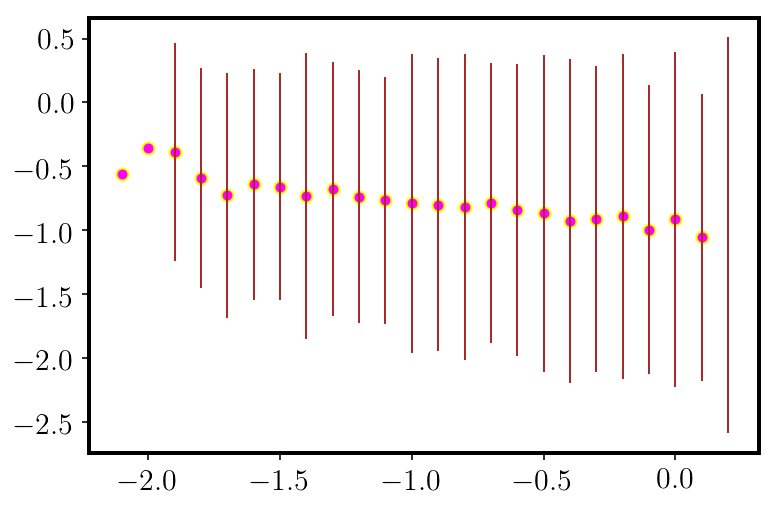

In [654]:
x,y = logEddRatio[m].data, sf4000[m].data
min_x, max_x , step_size = -2.2,0.2, 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
median_y_err = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
    if len(y[mask]) > 0 : 
        median_y_err[j] = 0.7413 * (np.percentile(y[mask],75) -np.percentile(y[mask],25))
    #np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
    # formula 3.38 , yellow book 
    
plt.scatter(mean_x[:-1], np.log10(median_y[:-1]), c = 'magenta', edgecolor='yellow')
plt.errorbar(mean_x, np.log10(median_y), yerr= np.log10(median_y_err), xerr = 1e-6, 
            ecolor='brown', elinewidth=1, fmt='none')



/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide

<ErrorbarContainer object of 3 artists>

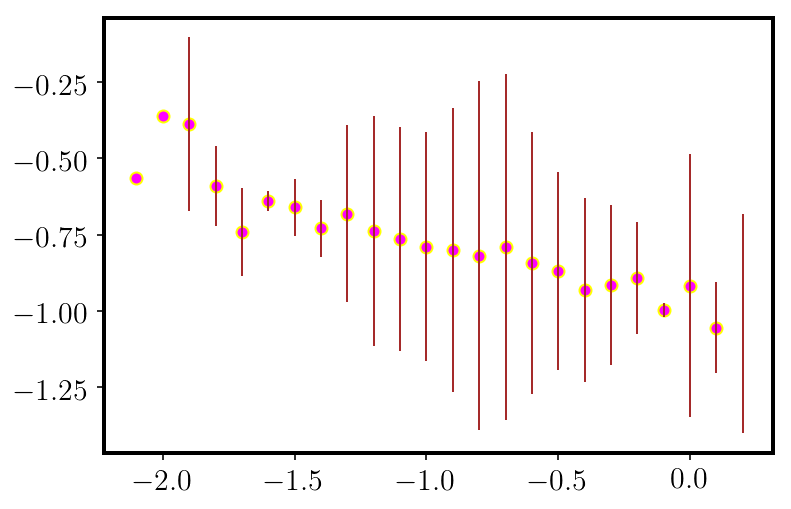

In [651]:
x,y = logEddRatio[m].data, np.log10(sf4000[m].data)
min_x, max_x , step_size = -2.2,0.2, 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
median_y_err = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
    median_y_err[j] = np.std(y[mask]) * np.sqrt(np.pi / 2*np.sum(mask)) 
    # formula 3.38 , yellow book 
    
plt.scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow')
plt.errorbar(mean_x, median_y, yerr= np.log10(median_y_err), xerr = 1e-6, 
            ecolor='brown', elinewidth=1, fmt='none')




Next : take the same distribution , and see what we get from using the linmix model, pythonic implementation... I hope it gives the same  as the TLS method! 

In [657]:
sigma_y

0.01

In [658]:
import linmix
# run the linmix x1,y1,
lm1 = linmix.LinMix(x=x1, y=y1, xsig=sigma_x, ysig=sigma_y, K=3)
lm1.run_mcmc(silent=True)

# store the MCMC chains 
np.save('linmix_M10_data_Shen2011_SFinf_LEdd_fit_medians' , lm1.chain[:])


In [669]:
lm1[:]['alpha']

array([-0.93961053, -0.93371057, -0.95434181, ..., -0.86471151,
       -0.87967421, -0.83453798])

In [673]:
lm1 = np.load('linmix_M10_data_Shen2011_SFinf_LEdd_fit_medians.npy')
# The results of fitting medians are the same : slope 
# same as TLS , -0.178  
# offset
a = lm1[:]['alpha']
alpha1 = np.mean(a)
alpha1_err = np.std(a)

# slope 
b = lm1[:]['beta']
beta1 = np.mean(b)
beta1_err = np.std(b)

print('alpha = ', alpha1, ' +/- ', alpha1_err)
print('beta = ', beta1, ' +/- ', beta1_err)



alpha =  -0.9245484103631118  +/-  0.03858751621187169
beta =  -0.17825224695628258  +/-  0.03489886752316531


(0, 0.5)

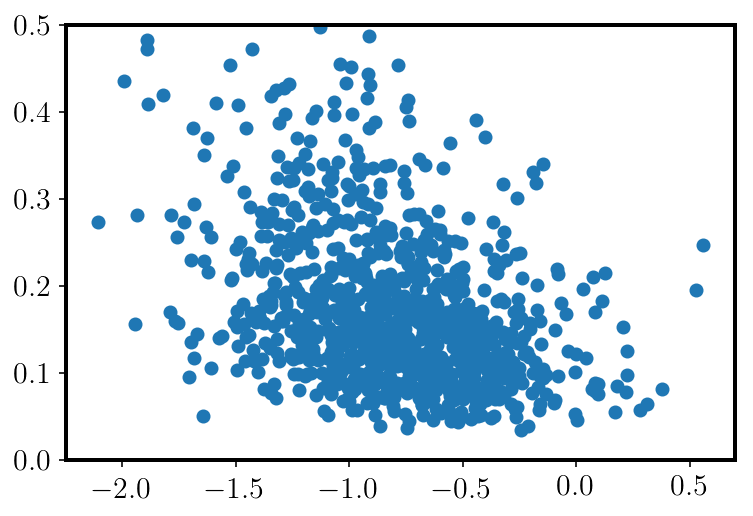

In [664]:
plt.scatter(x,y)
plt.ylim(0,0.5)

In [665]:
# How about fitting the data ? 
x1=x ; y1 = y
sigma_x = 0.2; sigma_y=0.01 
lm1 = linmix.LinMix(x=x1, y=y1, xsig=sigma_x, ysig=sigma_y, K=3)
lm1.run_mcmc(silent=True)

# store the MCMC chains 
np.save('linmix_M10_data_Shen2011_SFinf_LEdd_fit_xy' , lm1.chain[:])



In [675]:
lm1 = np.load('linmix_M10_data_Shen2011_SFinf_LEdd_fit_xy.npy')

# fitting xy data it finds a different slope :  0.0223
# i.e. very very flat ... 

# offset 
a = lm1[:]['alpha']
alpha1 = np.mean(a)
alpha1_err = np.std(a)
# slope 
b = lm1[:]['beta']
beta1 = np.mean(b)
beta1_err = np.std(b)

print('alpha = ', alpha1, ' +/- ', alpha1_err)
print('beta = ', beta1, ' +/- ', beta1_err)

alpha =  0.2662689682617656  +/-  0.11663385020659624
beta =  0.022309652362702628  +/-  0.13424204856850933


(array([  24.,  166.,  698., 1776., 2782., 2559., 1383.,  506.,  100.,
           6.]),
 array([-0.14672453, -0.06165825,  0.02340803,  0.10847432,  0.1935406 ,
         0.27860688,  0.36367316,  0.44873945,  0.53380573,  0.61887201,
         0.70393829]),
 <a list of 10 Patch objects>)

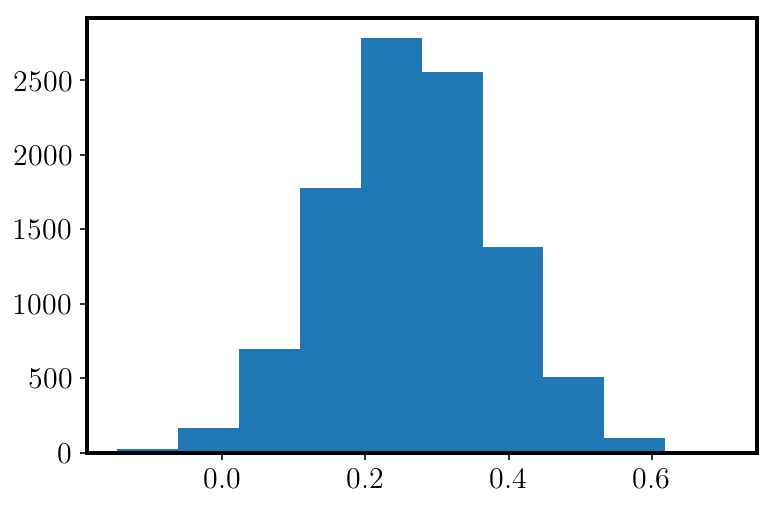

In [677]:
plt.hist(a)